<a href="https://colab.research.google.com/github/Rayan76q/CLIP_analysis/blob/main/CLIP_restuctured_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLIP FairVLMed
==

This notebook implements CLIP-based medical image analysis for glaucoma detection using the FairVLMed dataset. It includes data loading, preprocessing, and a comprehensive inference class for zero-shot predictions.

Author: LALAOUI Rayan, ALEKSANYAN Volodya  
Research Project: OpenAI CLIP with Medical Dataset

# PACKAGE INSTALLATION AND IMPORTS

In [ ]:
# Install required packages
!pip install -U gdown
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install aif360 fairlearn
!pip install umap-learn
!pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l067omvb
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-l067omvb
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Core imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import clip

from tqdm import tqdm

from PIL import Image, ImageEnhance, ImageFilter
from pathlib import Path
import zipfile
import gdown

# Analysis and visualization imports
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns

# DATASET DOWNLOAD AND EXTRACTION


In [ ]:
def download_and_extract_dataset():
    """
    Downloads the FairVLMed dataset and metadata from Google Drive.
    Extracts dataset files and prepares them for processing.
    """
    print("Downloading dataset...")

    # Download main dataset zip file
    dataset_file_id = "12oJbYhO8losIkZirQUqkbJGtl7WvstH-"
    dataset_output = "dataset.zip"
    gdown.download(f"https://drive.google.com/uc?id={dataset_file_id}",
                   dataset_output, quiet=False)

    # Extract dataset
    print("Extracting dataset...")
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset")

    # Download metadata summary
    print("Downloading metadata...")
    metadata_file_id = "1ey9CpldpHXRWH3jMzveW9K6tYyfCpNuy"
    metadata_output = "metadata_summary.csv"
    gdown.download(f"https://drive.google.com/uc?id={metadata_file_id}",
                   metadata_output, quiet=False)

    print("Dataset download and extraction complete!")
    return metadata_output

In [ ]:
# Execute dataset download
metadata_path = download_and_extract_dataset()

# Verify download
!ls -l

Downloading...
From (original): https://drive.google.com/uc?id=12oJbYhO8losIkZirQUqkbJGtl7WvstH-
From (redirected): https://drive.google.com/uc?id=12oJbYhO8losIkZirQUqkbJGtl7WvstH-&confirm=t&uuid=133b4b45-2349-4911-a516-a2ee99b84be9
To: /content/dataset.zip
100%|██████████| 2.68G/2.68G [00:40<00:00, 66.1MB/s]


Extracting dataset...


Downloading...
From: https://drive.google.com/uc?id=1ey9CpldpHXRWH3jMzveW9K6tYyfCpNuy
To: /content/metadata_summary.csv
100%|██████████| 12.3M/12.3M [00:00<00:00, 38.7MB/s]

Dataset download and extraction complete!
total 2625924
drwxr-xr-x 6 root root       4096 Jun 14 18:49 dataset
-rw-r--r-- 1 root root 2676630544 May 21 09:45 dataset.zip
-rw-r--r-- 1 root root   12296934 May 21 10:37 metadata_summary.csv
drwxr-xr-x 1 root root       4096 Jun 12 13:36 sample_data


## DATA LOADING AND PREPROCESSING

In [ ]:
def load_metadata(metadata_path):
    """
    Loads and preprocesses the metadata CSV file.

    Args:
        metadata_path (str): Path to the metadata CSV file

    Returns:
        pd.DataFrame: Preprocessed metadata with cleaned filenames
    """
    print("Loading metadata...")
    df_summary = pd.read_csv(metadata_path)

    # Clean filename column by removing file extensions
    df_summary["filename"] = df_summary["filename"].apply(lambda x: x.split(".")[0])

    print(f"Loaded {len(df_summary)} metadata entries")
    return df_summary

def load_image_data(folder_path='./dataset/Test'):
    """
    Loads NPZ image files from the specified folder and extracts SLO fundus images.

    Args:
        folder_path (str): Path to the folder containing NPZ files

    Returns:
        pd.DataFrame: DataFrame with filenames and image data
    """
    print(f"Loading image data from {folder_path}...")

    data_list = []

    # Process each NPZ file in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.npz'):
            file_stem = os.path.splitext(filename)[0]
            npz_path = os.path.join(folder_path, filename)

            try:
                # Load NPZ data
                npz_data = np.load(npz_path, allow_pickle=True)

                # Extract SLO fundus image
                data_entry = {
                    "filename": file_stem,
                    "slo_fundus": npz_data["slo_fundus"],
                }
                data_list.append(data_entry)

            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue

    print(f"Successfully loaded {len(data_list)} image entries")
    return pd.DataFrame(data_list)

def merge_data_and_metadata(image_df, metadata_df):
    """
    Merges image data with metadata based on filename.

    Args:
        image_df (pd.DataFrame): DataFrame with image data
        metadata_df (pd.DataFrame): DataFrame with metadata

    Returns:
        pd.DataFrame: Merged DataFrame with images and metadata
    """
    print("Merging image data with metadata...")

    # Merge on filename, keeping only matching entries
    merged_df = pd.merge(image_df, metadata_df, on='filename', how='inner')
    merged_df = merged_df.drop(columns=["use"], errors='ignore')

    print(f"Merged dataset contains {len(merged_df)} entries")
    return merged_df

In [ ]:
# Execute data loading and preprocessing
df_summary = load_metadata(metadata_path)
df_images = load_image_data()
df = merge_data_and_metadata(df_images, df_summary)
summaries = df["gpt4_summary"]

df_images = load_image_data(folder_path="./dataset/Training")
df_train = merge_data_and_metadata(df_images, df_summary)

df_images = load_image_data(folder_path="./dataset/Validation")
df_val = merge_data_and_metadata(df_images, df_summary)

print("Dataset Summary:")
print(df.head())

Loading metadata...
Loaded 10000 metadata entries
Loading image data from ./dataset/Test...
Successfully loaded 2000 image entries
Merging image data with metadata...
Merged dataset contains 2000 entries
Loading image data from ./dataset/Training...
Successfully loaded 7000 image entries
Merging image data with metadata...
Merged dataset contains 7000 entries
Loading image data from ./dataset/Validation...
Successfully loaded 1000 image entries
Merging image data with metadata...
Merged dataset contains 1000 entries
Dataset Summary:
     filename                                         slo_fundus    age  \
0  data_09183  [[30, 29, 28, 33, 31, 28, 32, 31, 30, 27, 25, ...  74.44   
1  data_09261  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  69.96   
2  data_08655  [[14, 11, 13, 11, 12, 11, 13, 16, 12, 14, 17, ...  61.52   
3  data_09605  [[3, 2, 3, 2, 5, 5, 2, 5, 5, 2, 4, 3, 4, 4, 4,...  65.40   
4  data_09749  [[20, 19, 19, 22, 22, 22, 21, 23, 23, 23, 21, ...  72.58   

   gender 

# CLIP INFERENCE CLASS

In [ ]:
class RunCLIP:
  def __init__(self, images, model_name="ViT-B/32", metadata = None):
    self.metadata = metadata
    self.images = images
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model, self.preprocess = clip.load(model_name, self.device)
    self.model_name = model_name
    self.run_result = None
    self.features = None

  def setClasses(self, classes_dict):
    self.classes_dict = classes_dict
    self.classes = []
    self.yes_class_index = -1
    for cat in classes_dict.values():
      for idx, c in enumerate(cat):
        self.classes.append(c[1])
        if c[1] == "yes":
            self.yes_class_index = len(self.classes) - 1

  def setModel(self, model):
    self.model = model
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model.to(self.device)


  def _encode_image(self, image):
    image_input = self.preprocess(Image.fromarray(image.astype(np.uint8))).unsqueeze(0).to(self.device)
    with torch.no_grad():
        image_features = self.model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

  def _encode_text(self, text_list):
      text_inputs = torch.cat([clip.tokenize(text, truncate = True) for text in text_list]).to(self.device)
      with torch.no_grad():
          text_features = self.model.encode_text(text_inputs)
          text_features /= text_features.norm(dim=-1, keepdim=True)
      return text_features

  def _get_text_classes(self):
      return [f"{c[0]}" for category_list in self.classes_dict.values() for c in category_list]

  def _compute_similarity_with_metadata(self, image_features, metadata_text):
    text_meta_features = self._encode_text(metadata_text).to(self.device)

    text_classes = self._get_text_classes()
    text_features = self._encode_text(text_classes)

    img_similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    meta_similarity = (100.0 * text_meta_features @ text_features.T).softmax(dim=-1)

    return torch.max(img_similarity,meta_similarity)

  def _compute_similarity_standard(self, image_features):
      text_classes = self._get_text_classes()
      text_features = self._encode_text(text_classes)
      return (100.0 * image_features @ text_features.T).softmax(dim=-1)

  def _get_top_predictions(self, similarity, topk):
      values, indices = similarity[0].topk(topk)
      return values.cpu().detach().numpy(), indices.cpu().detach().numpy()

  def _create_description(self, indices, similarity, topk):
      desc = {k: None for k in self.classes_dict.keys()}

      for j in range(topk):
          predicted_class = self.classes[indices[j].item()]
          for k in desc.keys():
              if predicted_class in [c[1] for c in self.classes_dict[k]] and desc[k] is None:
                  desc[k] = predicted_class

      desc["similarity_score"] = similarity[0][self.yes_class_index].cpu().item()
      return desc

  def _plot_single_image_results(self, image, top_probs, top_classes, image_idx, n_rows, n_cols):
      plt.subplot(n_rows, n_cols, 2 * image_idx + 1)
      plt.imshow(image)
      plt.axis("off")

      plt.subplot(n_rows, n_cols, 2 * image_idx + 2)
      y = np.arange(top_probs.shape[-1])
      plt.grid()
      plt.barh(y, top_probs)
      plt.gca().invert_yaxis()
      plt.gca().set_axisbelow(True)
      plt.yticks(y, [self.classes[index] for index in top_classes])
      plt.xlabel("probability")

  def runPreds(self, topk=8, plot_preview=True, metadata_text=None):
      if metadata_text is not None:
          assert len(metadata_text) == len(self.images), \
          "Metadata text must have the same length as images."
      else:
          if not hasattr(self, 'classes'):
              raise ValueError("Classes not set. Call setClasses() first.")
          if self.yes_class_index == -1:
              raise ValueError("Could not find the 'yes' class index. Ensure 'yes' is in your classes_dict values.")

      topk = min(topk, len(self.classes))

      all_image_features = []
      images_desc = []
      all_top_probs = []
      all_top_classes = []

      for i, image in enumerate(self.images):
          image_features = self._encode_image(image)
          all_image_features.append(image_features.cpu().numpy().squeeze())

          if metadata_text is not None:
              similarity = self._compute_similarity_with_metadata(image_features, metadata_text[i])
          else:
              similarity = self._compute_similarity_standard(image_features)

          top_probs, top_classes = self._get_top_predictions(similarity, topk)
          all_top_probs.append(top_probs)
          all_top_classes.append(top_classes)

          desc = self._create_description(top_classes, similarity, topk)
          images_desc.append(desc)

      if plot_preview:
          num_images = min(10, len(self.images))

          plt.figure(figsize=(16, 16))
          n_cols = 4
          n_rows = (num_images + 1) // 2

          for i in range(num_images):
              self._plot_single_image_results(
                  self.images[i], all_top_probs[i], all_top_classes[i],
                  i, n_rows, n_cols
              )

          plt.subplots_adjust(wspace=0.5, hspace=0.5)
          plt.show()

      self.features = np.vstack(all_image_features)
      self.run_result = pd.DataFrame(images_desc)

  def export_to_csv(self, path):
      if self.run_result is None:
          raise ValueError("runPreds() has not been called yet.")
      self.run_result.to_csv(path, index=False)

  def plot_latent_space(self, label_col: str, protected_attr: str = None,
                      n_neighbors: int = 3, min_dist: float = 0.1,
                      random_state: int = 42, show_predictions: bool = True):
    """
    Plot UMAP latent space with optional protected attribute coloring and prediction display.

    Parameters:
    -----------
    label_col : str
        Column name for predictions/labels
    protected_attr : str, optional
        Protected attribute from metadata to use for coloring points
    n_neighbors : int
        UMAP n_neighbors parameter
    min_dist : float
        UMAP min_dist parameter
    random_state : int
        Random seed for reproducibility
    show_predictions : bool
        Whether to show predictions as point shapes/markers
    """
    if self.run_result is None or self.features is None:
        raise ValueError("You must call runPreds() first.")

    if self.metadata is None:
        raise ValueError("Metadata is required when using protected attributes.")

    if label_col not in self.run_result.columns:
        raise ValueError(f"Column '{label_col}' not found in run_result DataFrame.")

    if protected_attr and protected_attr not in self.metadata.columns:
        raise ValueError(f"Protected attribute '{protected_attr}' not found in metadata DataFrame.")

    X = self.features
    y = self.run_result[label_col].values

    # Get protected attribute values if specified
    if protected_attr:
        protected_values = self.metadata[protected_attr].values
        # Create mask for valid data (both prediction and protected attribute)
        valid_mask = pd.notnull(y) & pd.notnull(protected_values)
    else:
        protected_values = None
        valid_mask = pd.notnull(y)

    # Filter data
    X = X[valid_mask]
    y = y[valid_mask]
    if protected_values is not None:
        protected_values = protected_values[valid_mask]

    if len(X) == 0:
        print("No valid data points found for plotting latent space.")
        return

    # UMAP embedding
    X_scaled = StandardScaler().fit_transform(X)
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    embedding = reducer.fit_transform(X_scaled)

    plt.figure(figsize=(12, 8))


    distinct_colors = [
        '#FF0000',  # Red
        '#0000FF',  # Blue
        '#00FF00',  # Green
        '#FF00FF',  # Magenta
        '#00FFFF',  # Cyan
        '#FFFF00',  # Yellow
        '#FF8000',  # Orange
        '#8000FF',  # Purple
        '#FF0080',  # Hot Pink
        '#80FF00',  # Lime
        '#0080FF',  # Light Blue
        '#FF8080',  # Light Red
        '#80FF80',  # Light Green
        '#8080FF',  # Light Blue
        '#FFFF80',  # Light Yellow
        '#FF80FF',  # Light Magenta
        '#80FFFF',  # Light Cyan
        '#C0C0C0',  # Silver
        '#800000',  # Maroon
        '#008000'   # Dark Green
    ]
    if protected_attr:
        # Color by protected attribute, shape by predictions
        unique_protected = np.unique(protected_values[pd.notnull(protected_values)])
        unique_predictions = np.unique(y[pd.notnull(y)])

        if len(unique_protected) > 20:
            print(f"Warning: Too many unique protected attribute values ({len(unique_protected)}). Plotting may not be clear.")


        color_map = {val: distinct_colors[i % len(distinct_colors)] for i, val in enumerate(unique_protected)}

        markers = ['o', 's', '^', 'v', 'D', 'P', 'X', '*', 'h', '+', '<', '>', 'd', 'p']
        marker_map = {pred: markers[i % len(markers)] for i, pred in enumerate(unique_predictions)}

        # Plot points grouped by protected attribute and prediction
        for prot_val in unique_protected:
            for pred_val in unique_predictions:
                mask = (protected_values == prot_val) & (y == pred_val)
                if np.any(mask):
                    plt.scatter(embedding[mask, 0], embedding[mask, 1],
                              s=60, color=color_map[prot_val],
                              marker=marker_map[pred_val],
                              label=f'{protected_attr}={prot_val}, {label_col}={pred_val}',
                              alpha=0.8, edgecolors='white', linewidth=1.2)

        plt.title(f'UMAP of CLIP features\nColored by {protected_attr}, Shaped by {label_col}', fontsize=14)

    else:
        # Original behavior - color by predictions only
        unique_labels = np.unique(y)

        if len(unique_labels) > 20:
            print(f"Warning: Too many unique labels ({len(unique_labels)}). Plotting may not be clear.")

        color_map = {lbl: distinct_colors[i % len(distinct_colors)] for i, lbl in enumerate(unique_labels)}

        for lbl in unique_labels:
            mask_lbl = (y == lbl)
            plt.scatter(embedding[mask_lbl, 0], embedding[mask_lbl, 1],
                      s=50, color=color_map[lbl], label=lbl, alpha=0.8,
                      edgecolors='white', linewidth=1)

        plt.title(f'UMAP of CLIP features colored by {label_col}', fontsize=14)

    plt.gca().set_aspect('equal', 'datalim')

    if protected_attr:
        plt.legend(title=f'{protected_attr} & {label_col}',
                  bbox_to_anchor=(1.05, 1), loc='upper left',
                  fontsize=8, title_fontsize=10)
    else:
        plt.legend(title=label_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('UMAP 1', fontsize=12)
    plt.ylabel('UMAP 2', fontsize=12)
    plt.tight_layout()
    plt.show()

## INITIAL TESTING AND EVALUATION

In [ ]:
def test_basic_clip_inference(df):
    """
    Test basic CLIP inference without metadata for glaucoma detection.

    Args:
        df (pd.DataFrame): Dataset with images and labels

    Returns:
        tuple: (RunCLIP instance, accuracy)
    """
    print("Testing basic CLIP inference...")

    # Initialize CLIP runner
    test = RunCLIP(list(df["slo_fundus"]), metadata= df.drop("slo_fundus", axis=1))
    test.setClasses({
       "pred": [("a medical picture of a person with glaucoma", "yes"),
                ("a medical picture of a person without glaucoma", "no")]
    })

    # Run predictions
    test.runPreds()

    # Plot latent space
    test.plot_latent_space("pred")

    # Calculate accuracy
    merge = df.copy().drop(columns=[c for c in df.columns if c != "glaucoma"])
    merge["pred"] = test.run_result["pred"]
    accuracy = (merge['glaucoma'] == merge['pred']).sum() / len(merge) * 100

    print(f"Basic CLIP Accuracy: {accuracy:.2f}%")

    return test, accuracy

def evaluate_performance_by_race(df, clip_results):
    """
    Evaluate model performance across different racial groups.

    Args:
        df (pd.DataFrame): Dataset with demographic information
        clip_results (pd.DataFrame): CLIP prediction results
    """
    print("Evaluating performance by demographic groups...")

    # Combine results with demographic data
    results_df = clip_results.copy()
    results_df["label"] = df["glaucoma"]
    results_df["race"] = df["race"]

    # Calculate AUC for each racial group
    print("\nPerformance by Race:")
    print("-" * 40)

    for race, group_df in results_df.groupby("race"):
        try:
            auc = roc_auc_score(group_df["label"], group_df["similarity_score"])
            print(f"[{race}] AUC: {auc:.3f}")
        except Exception as e:
            print(f"[{race}] AUC: Could not calculate ({e})")

    return results_df

Starting basic CLIP inference test...
Testing basic CLIP inference...


100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 37.8MiB/s]


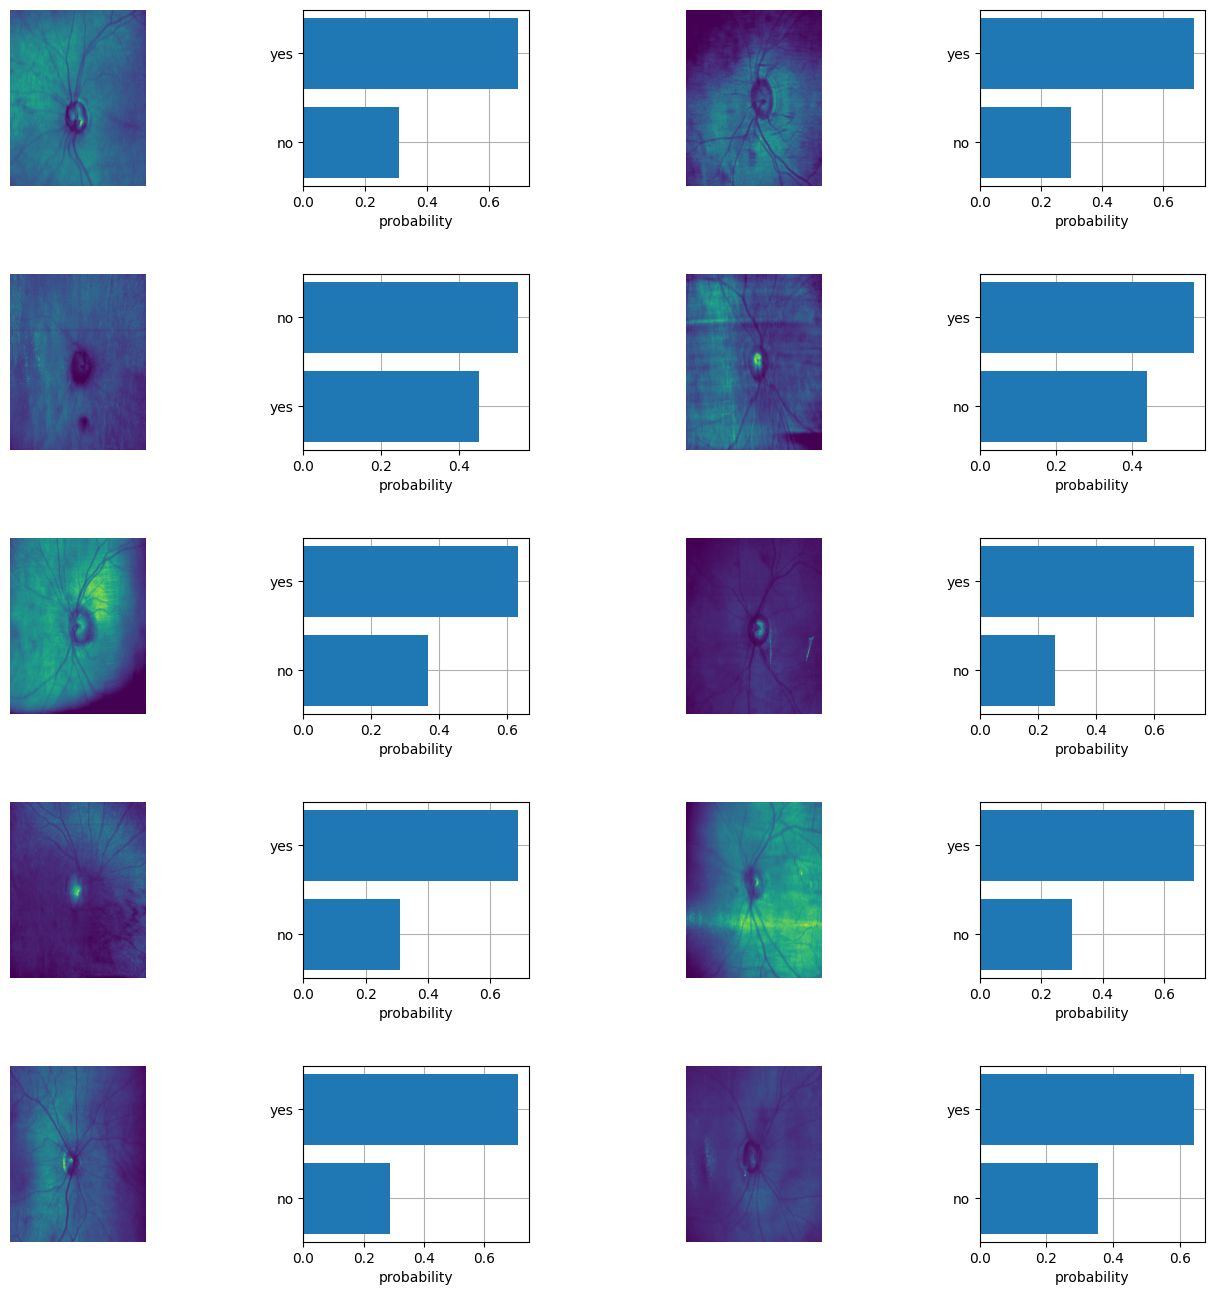

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


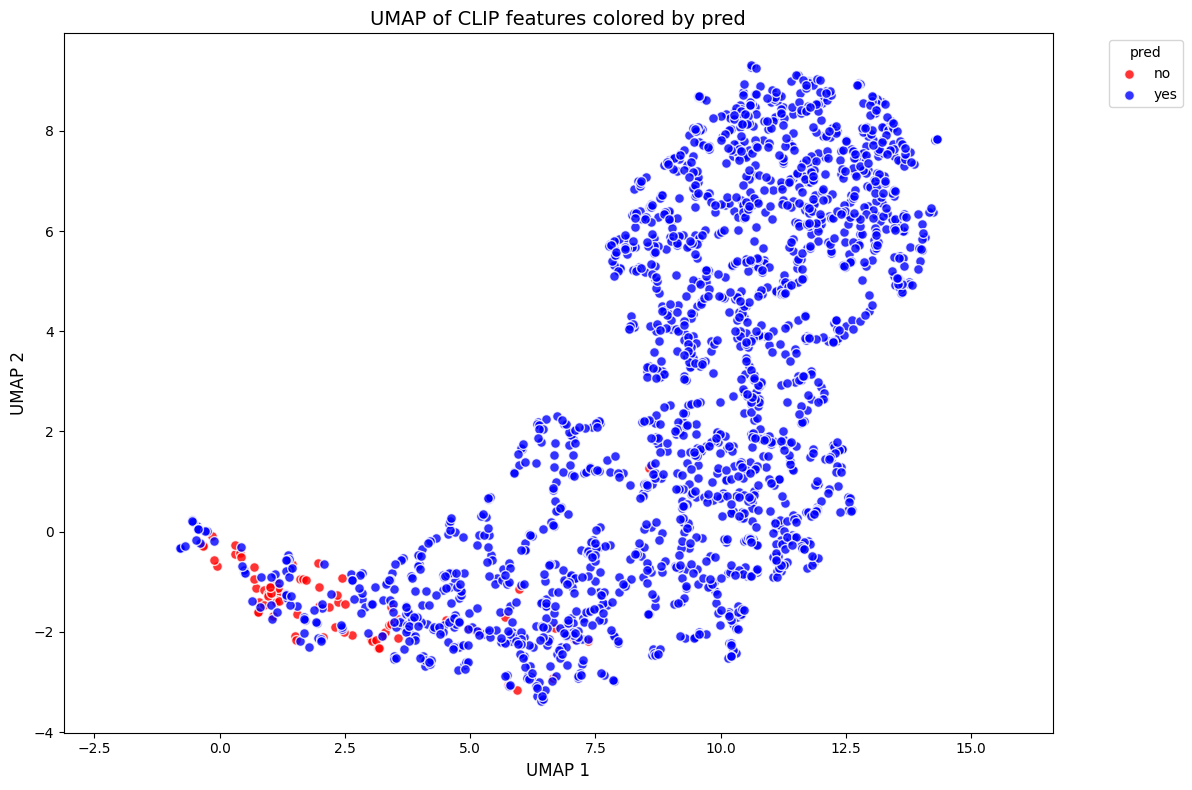

Basic CLIP Accuracy: 49.05%
Evaluating performance by demographic groups...

Performance by Race:
----------------------------------------
[asian] AUC: 0.423
[black] AUC: 0.401
[white] AUC: 0.484


In [ ]:
print("Starting basic CLIP inference test...")
clip_runner, basic_accuracy = test_basic_clip_inference(df)
demographic_results = evaluate_performance_by_race(df, clip_runner.run_result)

# Essayons de plus visualiser nos données

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


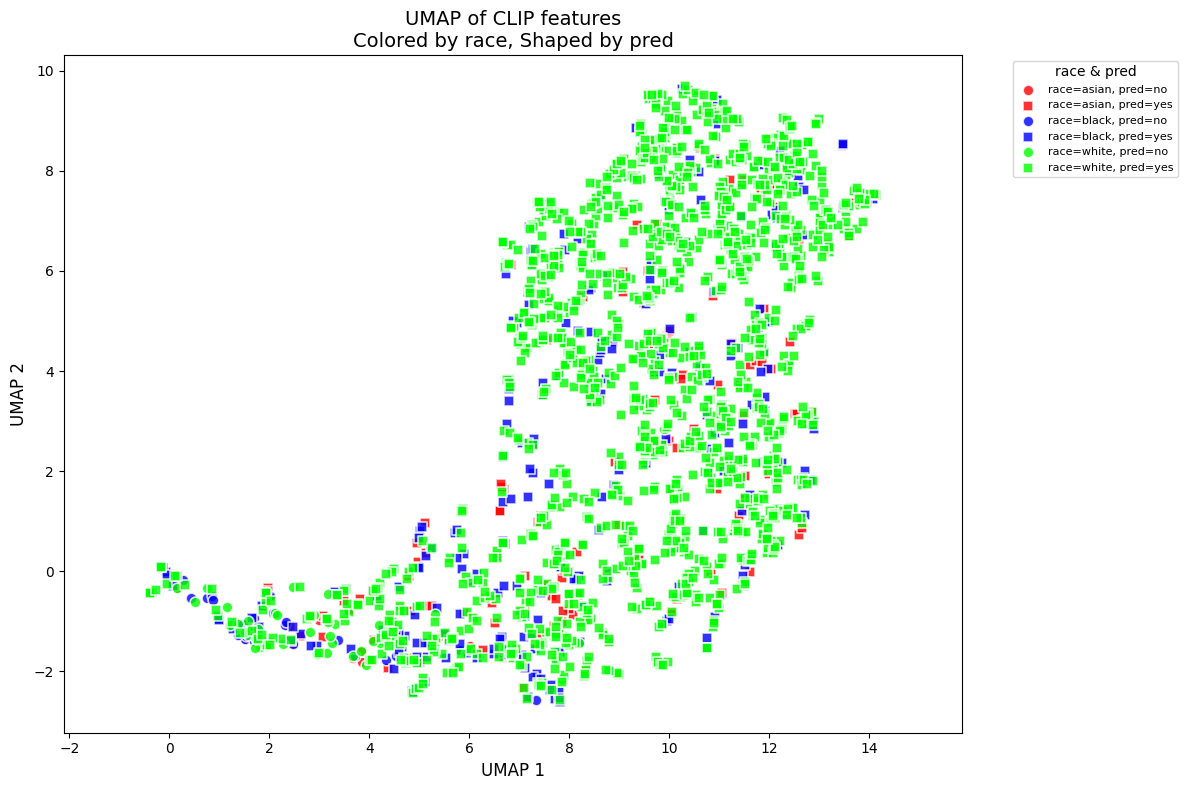

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


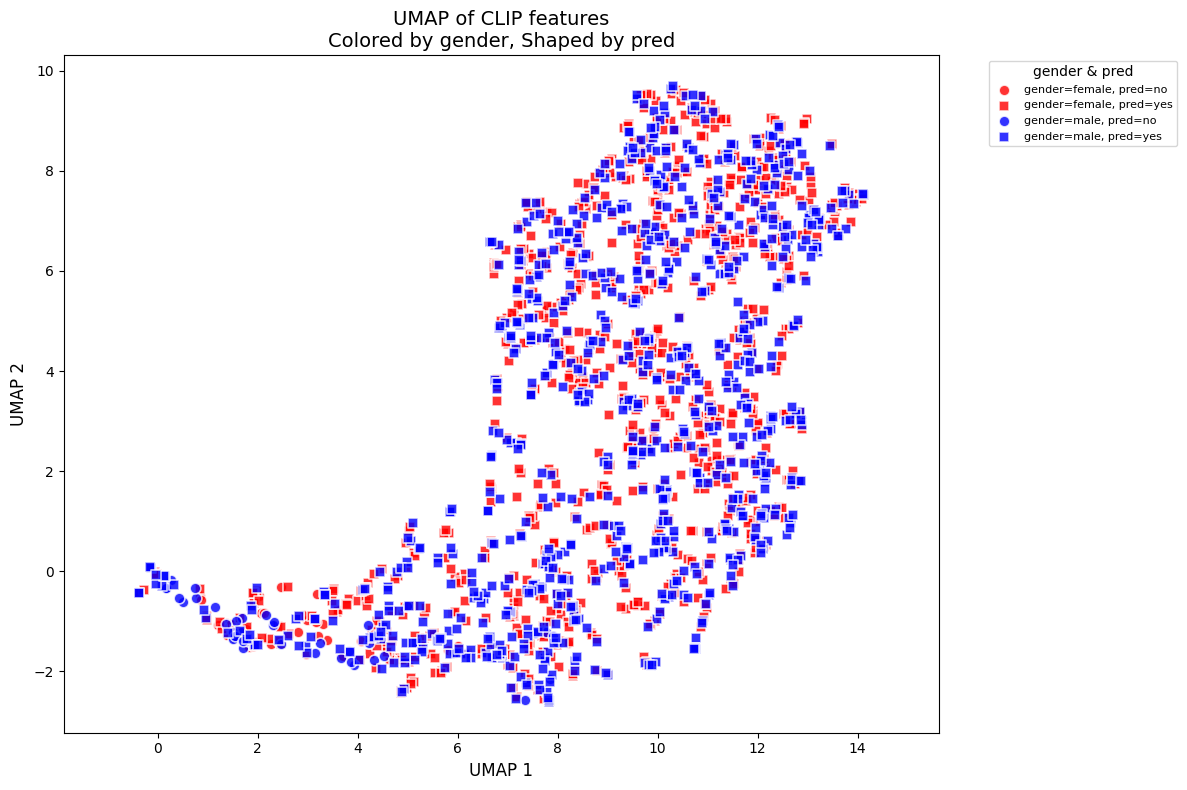

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


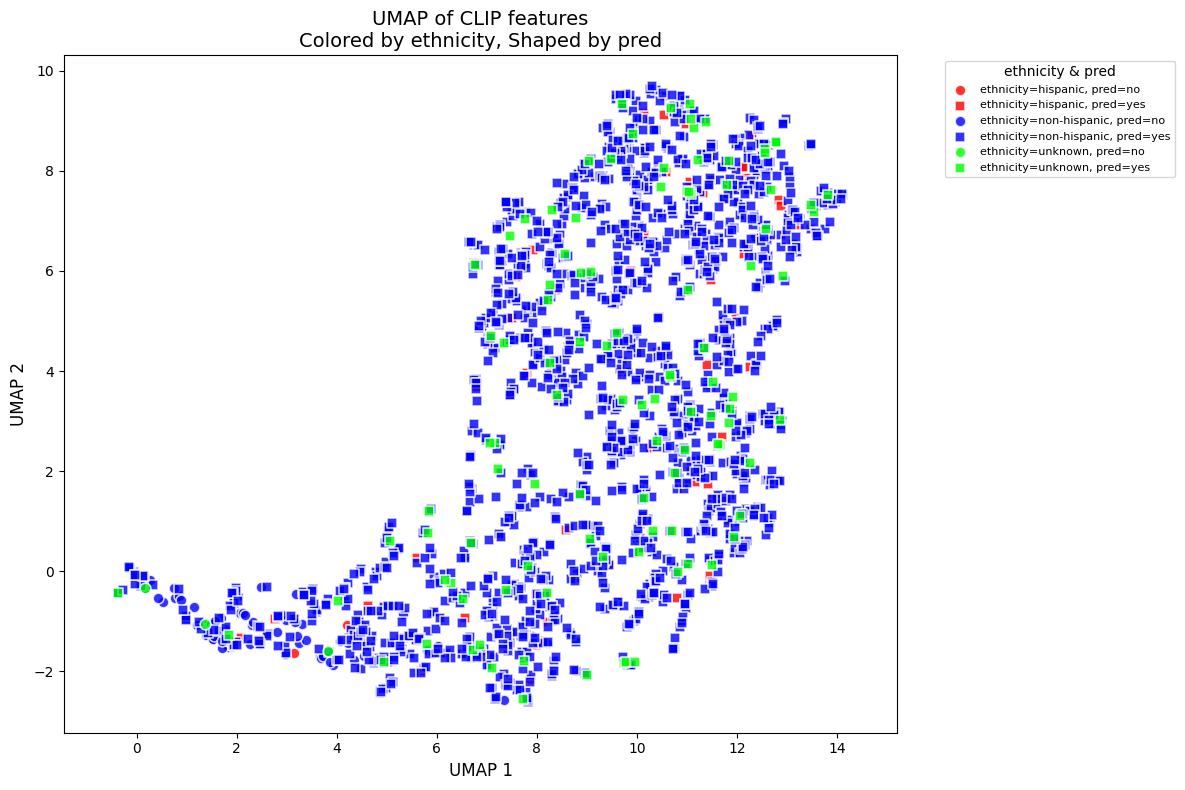

In [ ]:
clip_runner.plot_latent_space(protected_attr="race", label_col="pred")
clip_runner.plot_latent_space(protected_attr="gender", label_col="pred")
clip_runner.plot_latent_space(protected_attr="ethnicity", label_col="pred")

# Fine Tuning

In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, use_split, dataset_root, metadata_path, preprocess):
        self.use_split = use_split.lower()
        self.root_dir = os.path.join(dataset_root, use_split.capitalize())
        self.annotations = pd.read_csv(metadata_path)
        self.annotations["use"] = self.annotations["use"].str.strip().str.lower()
        self.annotations = self.annotations[self.annotations["use"] == self.use_split]
        self.annotations = self.annotations[self.annotations["filename"].str.lower().str.endswith('.npz')]
        self.annotations = self.annotations.reset_index(drop=True)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        npz_path = os.path.join(self.root_dir, self.annotations.iloc[idx]["filename"])
        npz_data = np.load(npz_path, allow_pickle=True)
        image_data = npz_data["slo_fundus"]
        image = self.preprocess(Image.fromarray(image_data.astype(np.uint8)).convert("RGB"))
        text = "image of an eye with glaucoma" if self.annotations.iloc[idx]["glaucoma"] == "yes"  else "image of an eye without glaucoma"     #text to associate to the image
        return image, text

# Utils

In [ ]:
def compute_metrics(logits, labels):
    """Compute accuracy and probabilities for AUC"""
    preds = logits.argmax(dim=1)
    probs = torch.softmax(logits, dim=1)[:, 1]  # Probability of positive class
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct, total, preds.detach().cpu().numpy(), probs.detach().cpu().numpy()

def evaluate_model(model, classifier, dataloader, criterion, device):
    """Evaluate model on given dataloader"""
    model.eval()
    classifier.eval()

    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = torch.tensor([1 if label == 'image of an eye with glaucoma' else 0 for label in labels]).to(device)

            # Extract CLIP features
            image_features = model.encode_image(images).float()

            # Classify
            logits = classifier(image_features)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            correct, total, preds, probs = compute_metrics(logits, labels)

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    auc = roc_auc_score(all_labels, all_probs)

    return avg_loss, accuracy, auc, all_preds, all_labels, all_probs


## TEXT & IMAGE TUNING

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset_root = "/content/dataset"
metadata_path = "/content/metadata_summary.csv"

train_dataset = GlaucomaDataset("training", dataset_root, metadata_path, preprocess)
val_dataset   = GlaucomaDataset("validation", dataset_root, metadata_path, preprocess)
test_dataset  = GlaucomaDataset("test", dataset_root, metadata_path, preprocess)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
VERBOSE = False

In [ ]:
# Fix temperature parameter BEFORE training
if hasattr(model, 'logit_scale'):
    print(f"Original logit_scale: {model.logit_scale.exp().item():.4f}")
    # Reset to a much smaller, safer value
    model.logit_scale.data.fill_(2.6592)  # ln(14.29) ≈ 2.6592, safer default
    # Freeze the temperature parameter to prevent it from growing during training
    model.logit_scale.requires_grad = False
    print(f"Fixed logit_scale: {model.logit_scale.exp().item():.4f}")
    print("Temperature parameter frozen during training")

# Ensure model is in training mode with gradients enabled
model.train()

# Freeze most of the model and only train the final layers
for name, param in model.named_parameters():
    param.requires_grad = False  # Freeze everything first
num_params = sum(p.numel() for p in model.parameters())

# Only unfreeze the safest parameters (layer norms and final projections)
trainable_params = []

for name, param in model.named_parameters():
    # Only train layer normalization parameters and avoid projection layers initially
    if any(layer in name for layer in ['ln_final', 'ln_1', 'ln_2']) and 'weight' in name:
        param.requires_grad = True
        trainable_params.append(name)
        if VERBOSE:
          print(f"Training parameter: {name} - Shape: {param.shape}")

print(f"Total trainable parameters: {len(trainable_params)} out of {num_params}")

Original logit_scale: 100.0000
Fixed logit_scale: 14.2849
Temperature parameter frozen during training
Total trainable parameters: 49 out of 151277313


In [ ]:
# If no trainable parameters found, add the safest ones
if len(trainable_params) == 0:
    print("No layer norm parameters found, using minimal set...")
    for name, param in model.named_parameters():
        if 'ln_final' in name:
            param.requires_grad = True
            trainable_params.append(name)
            if VERBOSE:
              print(f"Training parameter: {name} - Shape: {param.shape}")

In [ ]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [ ]:
trainable_params_list = [p for p in model.parameters() if p.requires_grad]
if len(trainable_params_list) == 0:
    print("WARNING: No trainable parameters found! Training will have no effect.")
    for name, param in model.named_parameters():
        if 'ln_final' in name and 'weight' in name:
            param.requires_grad = True
            trainable_params_list.append(param)
            break

optimizer = optim.Adam(trainable_params_list, lr=4e-5, eps=1e-8)

print(f"Optimizer created with {len(trainable_params_list)} trainable parameters")

Optimizer created with 49 trainable parameters


In [ ]:
nb_epochs = 5

In [ ]:
for epoch in range(nb_epochs):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch_idx, (images, texts) in enumerate(train_loader):
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)

        logits_per_image, logits_per_text = model(images, texts)

        logits_per_image = torch.clamp(logits_per_image, -20, 20)
        logits_per_text = torch.clamp(logits_per_text, -20, 20)

        if logits_per_image.abs().max() > 15 or logits_per_text.abs().max() > 15:
            print(f"Warning: Large logits detected - Image: {logits_per_image.abs().max():.2f}, Text: {logits_per_text.abs().max():.2f}")

        # Debug: Check logits range (remove after confirming fix works)
        if VERBOSE:
          if batch_idx == 0:  # Only print for first batch to avoid spam
              print(f"Epoch {epoch+1}, Batch {batch_idx}: Logits range - Image: [{logits_per_image.min():.2f}, {logits_per_image.max():.2f}], Text: [{logits_per_text.min():.2f}, {logits_per_text.max():.2f}]")

        # Ground truth labels (diagonal matching)
        ground_truth = torch.arange(len(images), device=device)

        loss_img_val = loss_img(logits_per_image, ground_truth)
        loss_txt_val = loss_txt(logits_per_text, ground_truth)
        loss = (loss_img_val + loss_txt_val) / 2

        if torch.isnan(logits_per_image).any() or torch.isnan(logits_per_text).any():
            print(f"NaN in logits detected at epoch {epoch+1}, batch {batch_idx}")
            break


        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}, batch {batch_idx}")
            print(f"Loss img: {loss_img_val.item()}, Loss txt: {loss_txt_val.item()}")
            break

        optimizer.zero_grad()
        loss.backward()

        # Check for NaN gradients before clipping (only check trainable params)
        nan_grads = False
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN gradient detected in {name}")
                nan_grads = True
                # Zero out the bad gradient instead of skipping
                param.grad.zero_()
                print(f"Zeroed gradient for {name}")

        # Always continue with the update (even if we had to zero some gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # More aggressive clipping
        optimizer.step()


        for name, param in model.named_parameters():
            if param.requires_grad and torch.isnan(param).any():
                print(f"NaN parameter detected in {name} after update")
                # Reset this parameter to prevent cascade failure
                nn.init.normal_(param.data, mean=0, std=0.01)
                print(f"Reset parameter {name} to prevent cascade failure")
                break

        total_loss += loss.item()
        num_batches += 1


    if num_batches > 0:
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")
    else:
        print(f"Epoch {epoch + 1} - Training stopped due to NaN")
        break


Epoch 1 - Loss: 2.7880
Epoch 2 - Loss: 2.7776
Epoch 3 - Loss: 2.7715
Epoch 4 - Loss: 2.7656
Epoch 5 - Loss: 2.7564


In [ ]:
test = RunCLIP(list(df["slo_fundus"]), metadata = df.drop("slo_fundus", axis=1))
test.setModel(model)
test.setClasses({
   "pred": [("a medical picture of a person with glaucoma", "yes") , ("a medical picture of a person without glaucoma", "no")]
})
test.runPreds(metadata_text=summaries , plot_preview=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


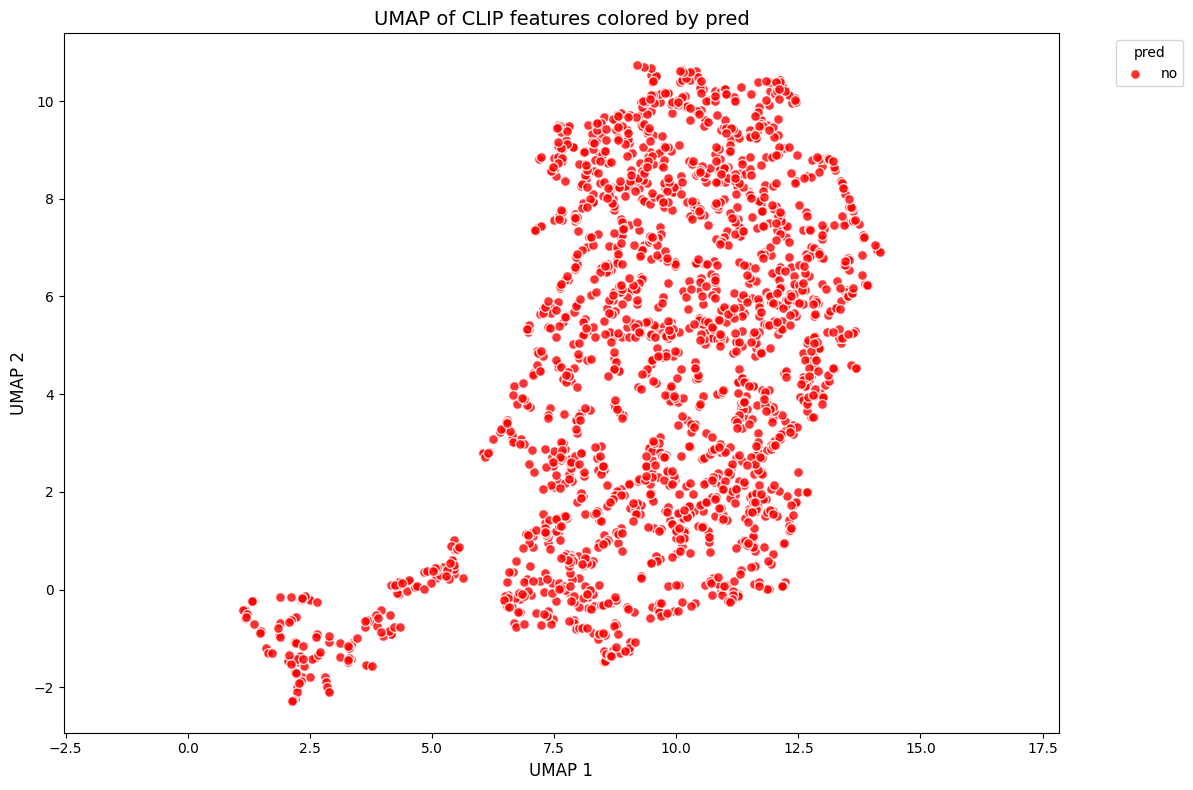

In [ ]:
test.plot_latent_space("pred")

In [ ]:
merge = df.copy().drop(columns = [c for c in df.columns if c != "glaucoma"])
merge["pred"] = test.run_result["pred"]
print(f"acc : { (merge['glaucoma'] == merge['pred']).sum() / len(merge)*100 : .2f}")

acc :  48.85


In [ ]:
df_fine_tuned_preds = df.copy()
df_fine_tuned_preds["pred"] = test.run_result["pred"]
df_fine_tuned_preds.to_csv("df_fine_tuned_preds.csv", index=False)

## Linear Fine Tuning model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Freeze CLIP parameters
for param in model.parameters():
    param.requires_grad = False

# Define linear classifier
classifier = nn.Linear(512, 2).float().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4) #, weight_decay)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


In [ ]:
best_val_auc = 0
best_epoch = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_aucs = []
val_aucs = []

nb_epoch = 5

In [ ]:
VERBOSE = True

In [ ]:
# Training loop
print("Starting linear fine-tuning of CLIP...")
print(f"Training on device: {device}")

for epoch in range(nb_epoch):
    # Training phase
    classifier.train()
    model.eval()  # Keep CLIP frozen

    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    all_train_probs = []

    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{nb_epoch} [Train]')

    for images, labels in train_pbar:
        images = images.to(device)
        labels = torch.tensor([1 if label == 'image of an eye with glaucoma' else 0 for label in labels]).to(device)

        # Extract CLIP features (no gradients)
        with torch.no_grad():
            image_features = model.encode_image(images)
        image_features = image_features.float()

        # Forward pass through classifier
        logits = classifier(image_features)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        correct, total, preds, probs = compute_metrics(logits, labels)

        all_train_preds.extend(preds)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_probs.extend(probs)

        # Update progress bar
        current_acc = correct / total
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.4f}'})

    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_acc = np.mean(np.array(all_train_preds) == np.array(all_train_labels))
    train_auc = roc_auc_score(all_train_labels, all_train_probs)

    # Validation phase
    val_loss, val_acc, val_auc, val_preds, val_labels, val_probs = evaluate_model(
        model, classifier, val_loader, criterion, device
    )

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    # Learning rate scheduling
    # scheduler.step(val_auc)

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_epoch = epoch
        torch.save(classifier.state_dict(), 'best_linear_classifier.pth')

    if VERBOSE:
        print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
        print(f"         | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
        print(f"         | Best Val AUC: {best_val_auc:.4f} (Epoch {best_epoch+1})")
        print("-" * 80)

    # Early stopping
    if epoch - best_epoch > 10:  # Stop if no improvement for 10 epochs
        print(f"Early stopping at epoch {epoch+1}")
        break

Starting linear fine-tuning of CLIP...
Training on device: cuda


Epoch 1/5 [Train]: 100%|██████████| 438/438 [01:17<00:00,  5.65it/s, loss=0.6418, acc=0.6250]


Epoch  1 | Train Loss: 0.6652, Train Acc: 0.6080, Train AUC: 0.6471
         | Val Loss: 0.6560, Val Acc: 0.6250, Val AUC: 0.6638
         | Best Val AUC: 0.6638 (Epoch 1)
--------------------------------------------------------------------------------


Epoch 2/5 [Train]: 100%|██████████| 438/438 [01:16<00:00,  5.74it/s, loss=0.5990, acc=0.8750]


Epoch  2 | Train Loss: 0.6458, Train Acc: 0.6347, Train AUC: 0.6834
         | Val Loss: 0.6451, Val Acc: 0.6270, Val AUC: 0.6814
         | Best Val AUC: 0.6814 (Epoch 2)
--------------------------------------------------------------------------------


Epoch 3/5 [Train]: 100%|██████████| 438/438 [01:02<00:00,  7.04it/s, loss=0.6902, acc=0.5000]


Epoch  3 | Train Loss: 0.6378, Train Acc: 0.6401, Train AUC: 0.6939
         | Val Loss: 0.6389, Val Acc: 0.6360, Val AUC: 0.6907
         | Best Val AUC: 0.6907 (Epoch 3)
--------------------------------------------------------------------------------


Epoch 4/5 [Train]: 100%|██████████| 438/438 [01:04<00:00,  6.77it/s, loss=0.6930, acc=0.5000]


Epoch  4 | Train Loss: 0.6330, Train Acc: 0.6483, Train AUC: 0.7007
         | Val Loss: 0.6364, Val Acc: 0.6470, Val AUC: 0.6951
         | Best Val AUC: 0.6951 (Epoch 4)
--------------------------------------------------------------------------------


Epoch 5/5 [Train]: 100%|██████████| 438/438 [01:00<00:00,  7.27it/s, loss=0.7447, acc=0.5000]


Epoch  5 | Train Loss: 0.6294, Train Acc: 0.6540, Train AUC: 0.7055
         | Val Loss: 0.6329, Val Acc: 0.6510, Val AUC: 0.6978
         | Best Val AUC: 0.6978 (Epoch 5)
--------------------------------------------------------------------------------


In [ ]:
# Load best model
classifier.load_state_dict(torch.load('best_linear_classifier.pth'))

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
test_loss, test_acc, test_auc, test_preds, test_labels, test_probs = evaluate_model(
    model, classifier, test_loader, criterion, device
)
print("\n" + "="*40)
print("FINAL EVALUATION ON TEST SET")
print("="*40)

print(f"Number of Epochs: {nb_epoch}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


FINAL EVALUATION ON TEST SET
Number of Epochs: 5
Test Loss: 0.6281
Test Accuracy: 0.6430
Test AUC: 0.7049


In [ ]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Glaucoma', 'Glaucoma']))


Classification Report:
              precision    recall  f1-score   support

 No Glaucoma       0.63      0.67      0.65       977
    Glaucoma       0.66      0.62      0.64      1023

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



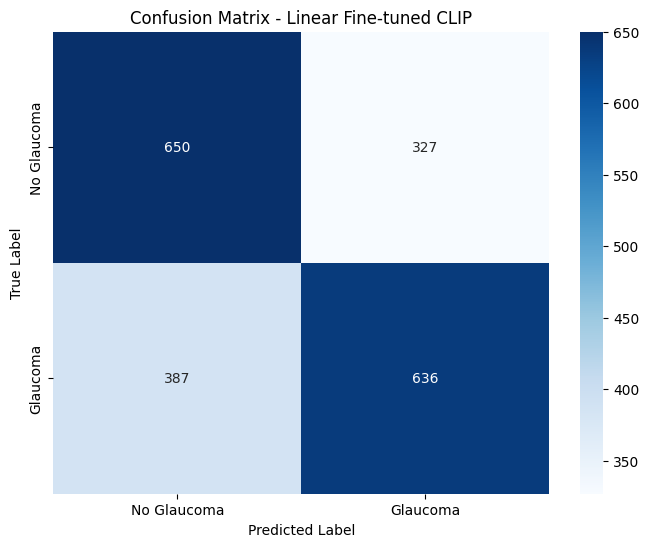

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Glaucoma', 'Glaucoma'], yticklabels=['No Glaucoma', 'Glaucoma'])
plt.title('Confusion Matrix - Linear Fine-tuned CLIP')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

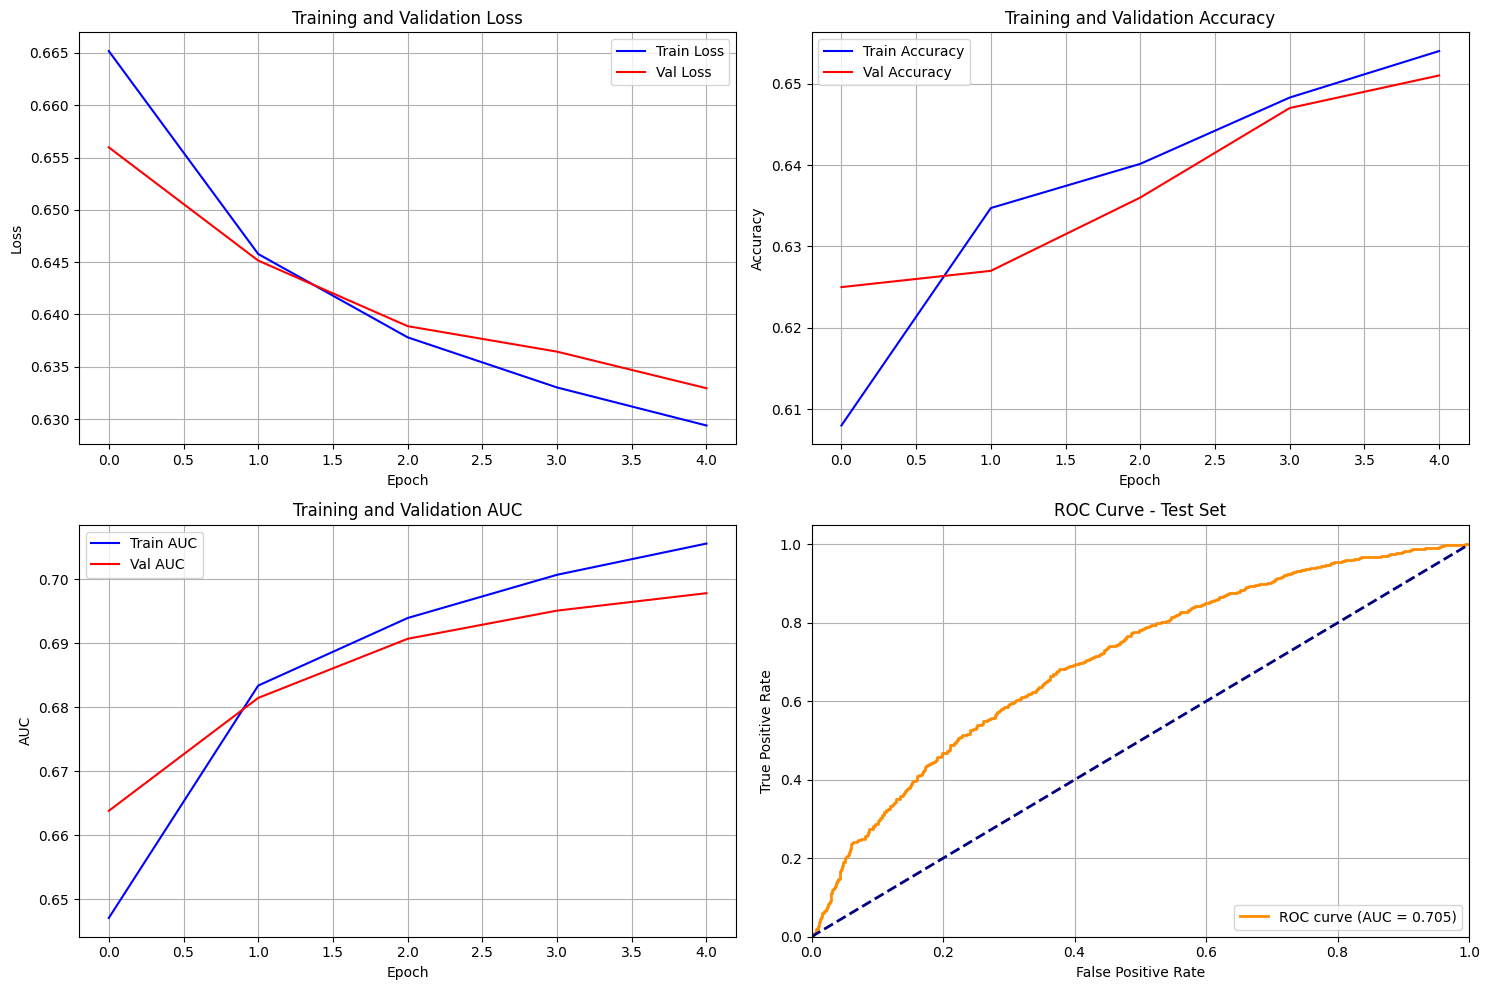

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', color='blue')
axes[0, 0].plot(val_losses, label='Val Loss', color='red')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', color='blue')
axes[0, 1].plot(val_accs, label='Val Accuracy', color='red')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# AUC curves
axes[1, 0].plot(train_aucs, label='Train AUC', color='blue')
axes[1, 0].plot(val_aucs, label='Val AUC', color='red')
axes[1, 0].set_title('Training and Validation AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True)

# ROC Curve for test set
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve - Test Set')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Evaluate on original test dataframe

In [ ]:
# Use the trained classifier to make predictions on our original test data
classifier.eval()
model.eval()

test_images = list(df["slo_fundus"])
predictions = []
probabilities = []

with torch.no_grad():
    for i in range(0, len(test_images), batch_size):  # Process in batches
        batch_images = test_images[i:i+batch_size]

        # Preprocess images
        batch_tensors = []
        for img in batch_images:
            img_tensor = preprocess(Image.fromarray(img.astype(np.uint8))).unsqueeze(0)
            batch_tensors.append(img_tensor)

        batch_tensor = torch.cat(batch_tensors).to(device)

        # Extract features and classify
        image_features = model.encode_image(batch_tensor).float()
        logits = classifier(image_features)
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)

        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs[:, 1].cpu().numpy())  # Probability of glaucoma

In [ ]:
# Convert predictions to yes/no format
pred_labels = ['yes' if pred == 1 else 'no' for pred in predictions]

In [ ]:
# Create results dataframe
df_linear_results = df.copy()
df_linear_results["pred"] = pred_labels
df_linear_results["pred_prob"] = probabilities

In [ ]:
# Calculate accuracy
accuracy = (df_linear_results['glaucoma'] == df_linear_results['pred']).sum() / len(df_linear_results) * 100
print(f"Overall Accuracy: {accuracy:.2f}%")

Overall Accuracy: 64.25%


In [ ]:
# Calculate AUC by race (fairness analysis)
print("Fairness Analysis by Race:")
for race, group_df in df_linear_results.groupby("race"):
    if len(group_df) > 1:  # Need at least 2 samples for AUC
        y_true = (group_df["glaucoma"] == "yes").astype(int)
        y_scores = group_df["pred_prob"]
        if len(np.unique(y_true)) > 1:  # Need both classes for AUC
            auc = roc_auc_score(y_true, y_scores)
            acc = (group_df['glaucoma'] == group_df['pred']).sum() / len(group_df) * 100
            print(f"[{race}] AUC: {auc:.3f}, Accuracy: {acc:.1f}%")
        else:
            acc = (group_df['glaucoma'] == group_df['pred']).sum() / len(group_df) * 100
            print(f"[{race}] Only one class present, Accuracy: {acc:.1f}%")


Fairness Analysis by Race:
[asian] AUC: 0.708, Accuracy: 62.7%
[black] AUC: 0.687, Accuracy: 63.3%
[white] AUC: 0.702, Accuracy: 64.6%


In [ ]:
# Save results
df_linear_results.to_csv("df_linear_finetuned_preds.csv", index=True)
print(f"Results saved to 'df_linear_finetuned_preds.csv'")
print(f"Number of 'yes' predictions: {(df_linear_results['pred'] == 'yes').sum()}")


Results saved to 'df_linear_finetuned_preds.csv'
Number of 'yes' predictions: 962


In [ ]:
# from google.colab import files

# files.download('df_linear_finetuned_preds.csv')

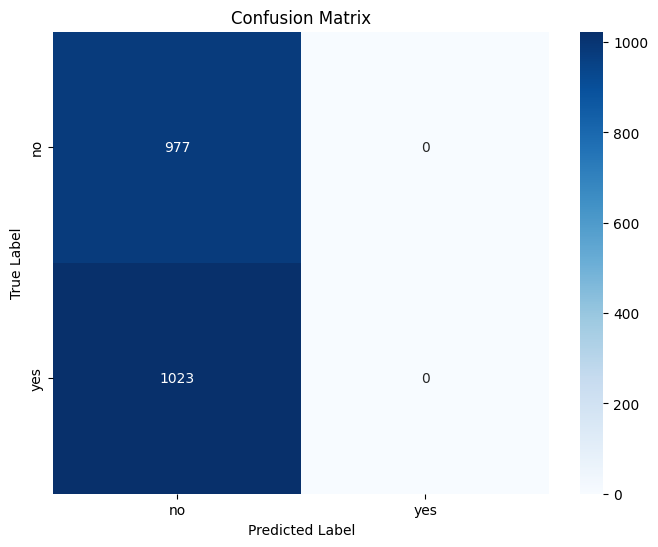

In [ ]:
true_labels_v1 = df_fine_tuned_preds['glaucoma']
predicted_labels_v1 = df_fine_tuned_preds['pred']

cm = confusion_matrix(true_labels_v1, predicted_labels_v1)

labels = ['no', 'yes']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Il y a visiblement une erreur, probablement dans les hyperparametres... Il faut qu'on revoit le code, car sur la feuille originelle qui nous sert de brouillon on n'a pas ce problème

## V2 du premier tuning

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) #Must set jit=False for training
train_dataloader = train_loader

#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16


In [ ]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [ ]:
#choosing parameters
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = 0

trainable_keywords = [
    'transformer.resblocks.10',
    'transformer.resblocks.11',
    'visual.transformer.resblocks.10',
    'visual.transformer.resblocks.11',
    #'ln_final',
    'text_projection',
    'visual.proj',
]


In [ ]:
for name, param in model.named_parameters():
    if any(k in name for k in trainable_keywords):
        param.requires_grad = True
        num_trainable_params += param.numel()
    else:
        param.requires_grad = False
print(f"Trainable params : {num_trainable_params} out of {num_params} ({100*num_trainable_params/num_params : .2f}% )")

Trainable params : 21135872 out of 151277313 ( 13.97% )


In [ ]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-6
)

In [ ]:
nb_epochs = 20

In [ ]:
import copy

model_snapshots = {}  # Dictionary to store snapshots

for epoch in range(nb_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()

        images, texts = batch
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)

        logits_per_image, logits_per_text = model(images, texts)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)

        total_loss = (loss_img(logits_per_image, ground_truth) +
                      loss_txt(logits_per_text, ground_truth)) / 2

        total_loss.backward()

        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

    # Snapshot every 5 epochs (1-based)
    if (epoch + 1) % 5 == 0:
        snapshot = copy.deepcopy(model.state_dict())
        model_snapshots[f"epoch_{epoch+1}"] = snapshot
        print(f"Snapshot saved at epoch {epoch+1}")

    print(f"EPOCH {epoch+1} : total_loss = {total_loss:.2f}")


EPOCH 1 : total_loss = 2.21
EPOCH 2 : total_loss = 2.23
EPOCH 3 : total_loss = 1.74
EPOCH 4 : total_loss = 1.99
Snapshot saved at epoch 5
EPOCH 5 : total_loss = 1.90
EPOCH 6 : total_loss = 1.91
EPOCH 7 : total_loss = 1.86
EPOCH 8 : total_loss = 1.69
EPOCH 9 : total_loss = 1.97
Snapshot saved at epoch 10
EPOCH 10 : total_loss = 1.90
EPOCH 11 : total_loss = 1.60
EPOCH 12 : total_loss = 1.71
EPOCH 13 : total_loss = 2.09
EPOCH 14 : total_loss = 1.54
Snapshot saved at epoch 15
EPOCH 15 : total_loss = 1.58
EPOCH 16 : total_loss = 1.52
EPOCH 17 : total_loss = 1.50
EPOCH 18 : total_loss = 1.50
EPOCH 19 : total_loss = 1.60
Snapshot saved at epoch 20
EPOCH 20 : total_loss = 1.86


In [ ]:
test = RunCLIP(list(df["slo_fundus"]), metadata = df.drop("slo_fundus", axis=1))
test.setModel(model)
test.setClasses({
   "pred": [("a medical picture of an eye retina with glaucoma", "yes") , ("a medical picture of an eye without glaucoma", "no")]
})
test.runPreds(metadata_text=summaries , plot_preview=False)

In [ ]:
merge = df.copy().drop(columns = [c for c in df.columns if c != "glaucoma"])
merge["pred"] = test.run_result["pred"]
print(f"acc : { (merge['glaucoma'] == merge['pred']).sum() / len(merge)*100 : .2f}")

acc :  64.30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


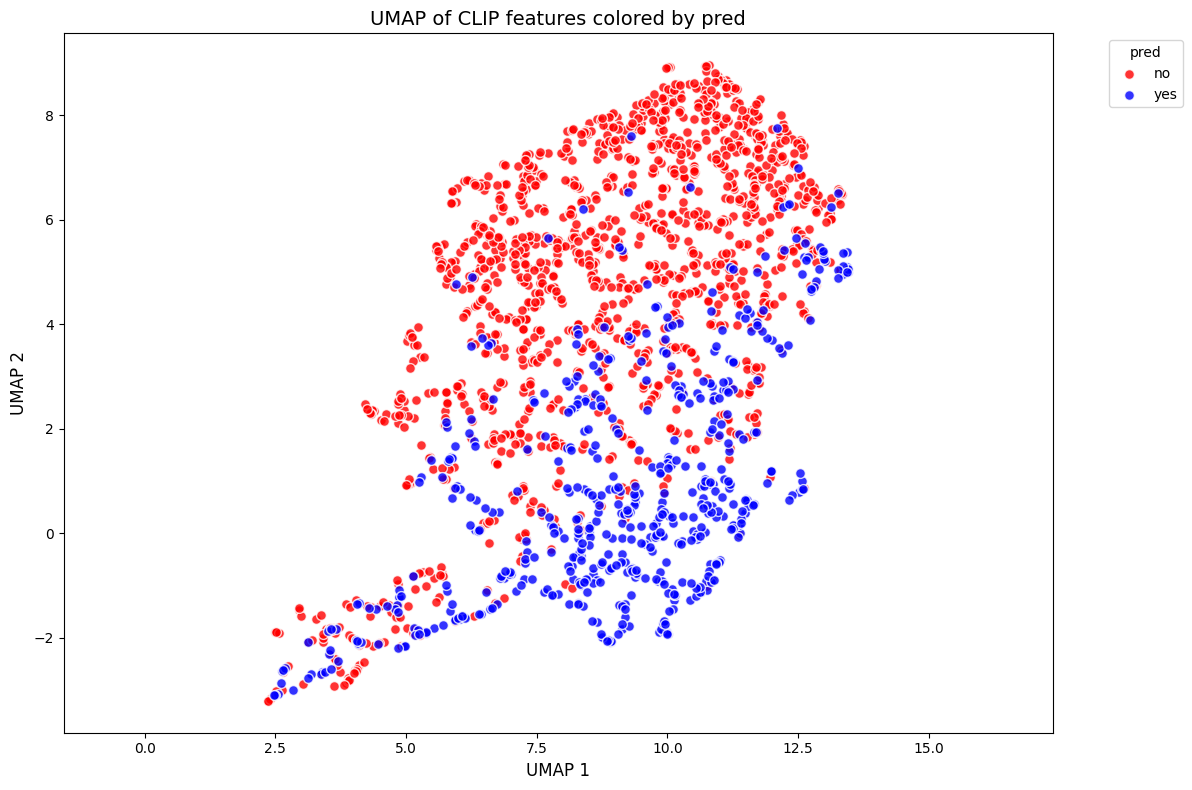

In [ ]:
test.plot_latent_space("pred")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


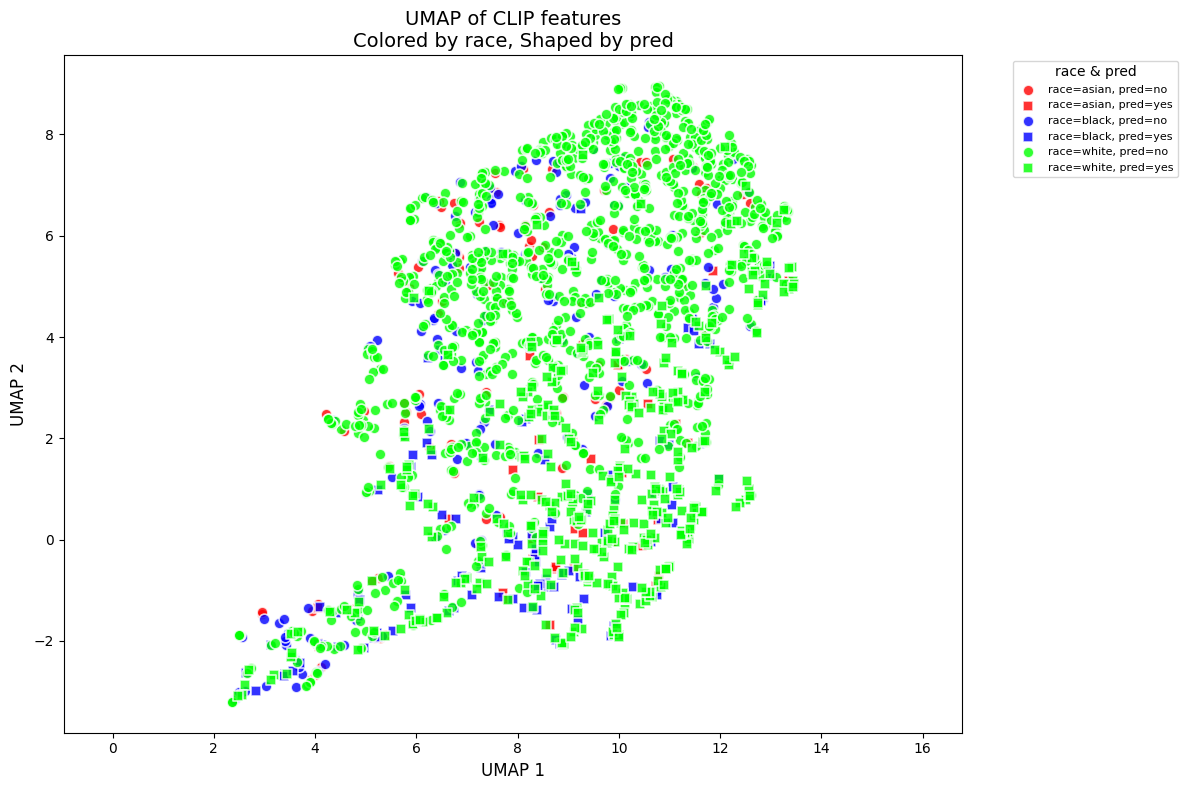

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


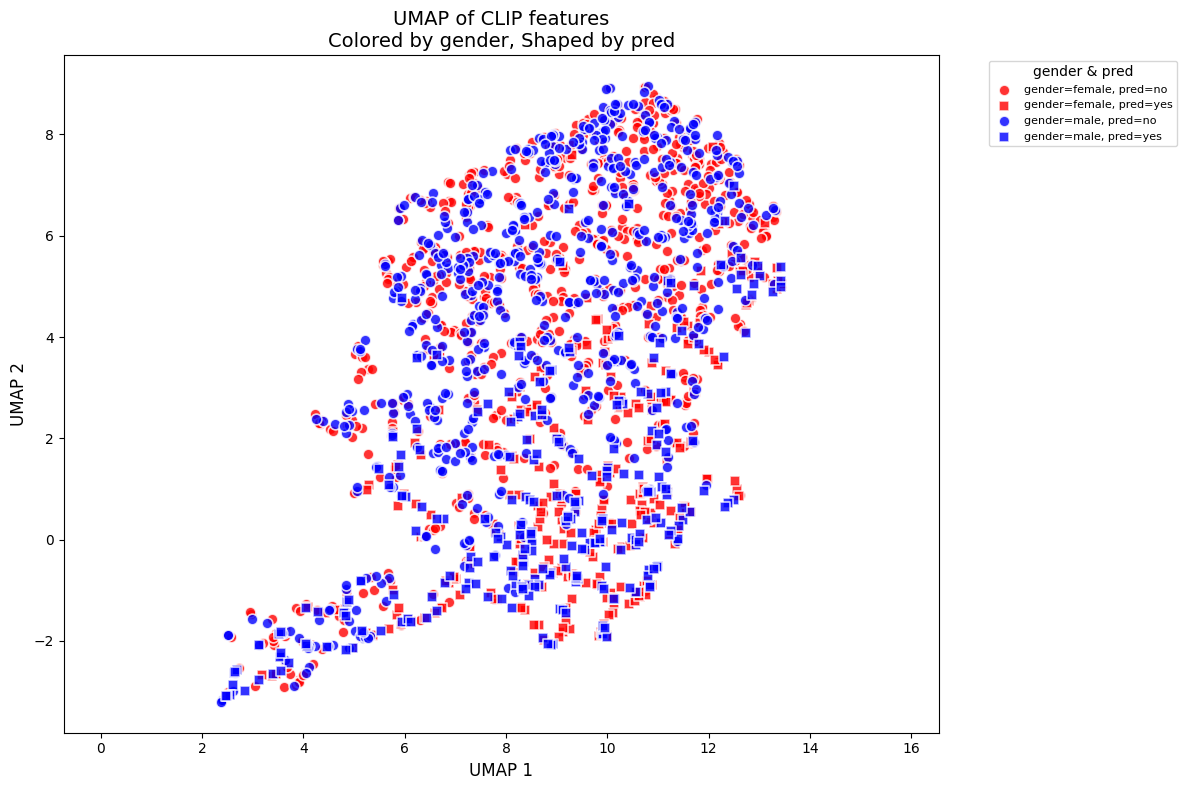

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


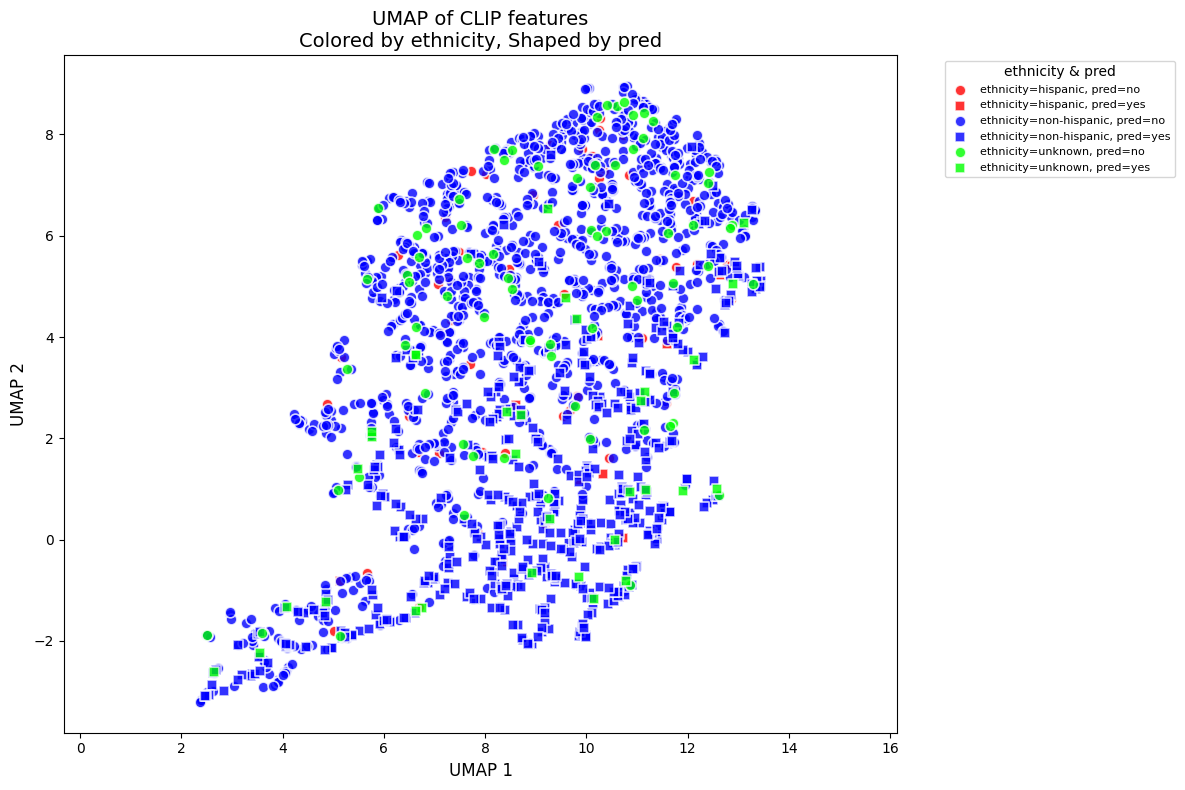

In [ ]:
test.plot_latent_space(protected_attr="race", label_col="pred")
test.plot_latent_space(protected_attr="gender", label_col="pred")
test.plot_latent_space(protected_attr="ethnicity", label_col="pred")

## Intra Class fine-tuning

In [ ]:
encoding = {"race" : {"white" : 1 , "black" :2 , "asian" : 3} ,
            "gender" : {"male" : 1 , "female" : 0},
            "ethnicity" : {"hispanic" : 0 , "non-hispanic" : 1},
            "language": {"english" : 1 , "spanish" : 0}
          }

In [ ]:
def custom_batches(df_train, protected_attribute, batch_size=32):
    groups = df_train[protected_attribute].unique()
    num_groups = len(groups)

    group_data = {}
    for group in groups:
        group_data[group] = df_train[df_train[protected_attribute] == group].reset_index(drop=True)

    batches = []
    group_indices = {group: 0 for group in groups}

    while True:
        current_batch = []

        for group in groups:
            if group_indices[group] < len(group_data[group]):
                current_batch.append(group_data[group].iloc[group_indices[group]])
                group_indices[group] += 1

        if len(current_batch) == 0:
            break

        remaining_slots = batch_size - len(current_batch)

        while remaining_slots > 0:
            added_sample = False

            for group in groups:
                if remaining_slots <= 0:
                    break
                if group_indices[group] < len(group_data[group]):
                    current_batch.append(group_data[group].iloc[group_indices[group]])
                    group_indices[group] += 1
                    remaining_slots -= 1
                    added_sample = True

            if not added_sample:
                break

        batch_df = pd.DataFrame(current_batch).reset_index(drop=True)
        batches.append(batch_df)

    return batches

def preprocess_batch(batch, preprocess, device, protected_attribute):
    images = batch['slo_fundus'].tolist()
    images = [Image.fromarray(img.astype(np.uint8)).convert("RGB") for img in images]
    labels = batch['glaucoma'].tolist()
    labels = ["image of an eye with glaucoma" if lab == "yes" else "image of an eye without glaucoma" for lab in labels]
    protected_attrs = batch[protected_attribute].map(encoding[protected_attribute]).tolist()

    images = torch.stack([preprocess(img) for img in images]).to(device)
    labels = clip.tokenize(labels).to(device)
    protected_attrs = torch.tensor(protected_attrs).to(device)

    return images, labels, protected_attrs

In [ ]:
def compute_latant_embedings(model, images):
  with torch.no_grad():
    image_features = model.encode_image(images)
    image_features = torch.nn.functional.normalize(image_features, dim=-1)
  return image_features

In [ ]:
def intra_class_fairness_loss(embedings, labels, ethnicities):
    loss = 0.0
    count = 0

    for label in ["no", "yes"]:
        ind = (labels == label)
        grp_embeds = embedings[ind]
        grp_eths = ethnicities[ind]

        for i in range(len(grp_embeds)):
            for j in range(i+1, len(grp_embeds)):
                if grp_eths[i] != grp_eths[j]:
                    dist = 1 - torch.cosine_similarity(
                        grp_embeds[i].unsqueeze(0), grp_embeds[j].unsqueeze(0), dim=1
                        )
                    loss += dist
                    count += 1
    #normalize loss
    if count > 0:
        loss = loss / count  # Average over all cross-ethnicity pairs
    else:
        loss = torch.tensor(0.0, device=embedings.device)

    return loss

In [ ]:
def compute_loss(model, preprocess, batch, protected_attribute ,coef1 = 1.0, coef2 = 0.7):
  """
  coef1 is for the contrastive part.
  coef2 is for the fairness part. Big coef2 means more fairness, less means better performance.
  """
  images , texts, protected_attrs = preprocess_batch(batch, preprocess, device, protected_attribute)

  image_features = compute_latant_embedings(model, images)

  logits_per_image, logits_per_text = model(images, texts)
  ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
  loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
  total_loss = coef1 * loss + coef2 * intra_class_fairness_loss(image_features, batch["glaucoma"], protected_attrs)

  return total_loss

In [ ]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) # Must set jit=False for training

if device == "cpu":
    model.float()
else:
    clip.model.convert_weights(model)

# Loss functions
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

trainable_keywords = [
    'transformer.resblocks.10',
    'transformer.resblocks.11',
    'visual.transformer.resblocks.10',
    'visual.transformer.resblocks.11',
    #'ln_final',
    'text_projection',
    'visual.proj',
]



In [ ]:
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = 0

for name, param in model.named_parameters():
    if any(k in name for k in trainable_keywords):
        param.requires_grad = True
        num_trainable_params += param.numel()
    else:
        param.requires_grad = False

print(f"Trainable params: {num_trainable_params} out of {num_params} ({100*num_trainable_params/num_params:.2f}%)")

Trainable params: 21135872 out of 151277313 (13.97%)


In [ ]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5
)

In [ ]:
protected_attribute = 'race'

nb_epochs = 30

batch_size = 32

contrastive_coef = 1.0
fairness_coef = 0.1

In [ ]:
for epoch in range(nb_epochs):
    model.train()
    total_epoch_loss = 0
    num_batches = 0

    batches = custom_batches(df_train, protected_attribute, batch_size=batch_size)

    for batch_idx, batch_df in enumerate(batches):
        optimizer.zero_grad()

        loss = compute_loss(model, preprocess, batch_df, protected_attribute, coef1=contrastive_coef, coef2=fairness_coef)
        loss.backward()
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        total_epoch_loss += loss.item()
        num_batches += 1


    avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0
    print(f"EPOCH {epoch + 1} - Average Loss: {avg_epoch_loss:.4f}")



EPOCH 1 - Average Loss: 3.4091
EPOCH 2 - Average Loss: 3.3466
EPOCH 3 - Average Loss: 3.3057
EPOCH 4 - Average Loss: 3.2546
EPOCH 5 - Average Loss: 3.1898
EPOCH 6 - Average Loss: 3.1156
EPOCH 7 - Average Loss: 3.0660
EPOCH 8 - Average Loss: 3.0398
EPOCH 9 - Average Loss: 3.0026
EPOCH 10 - Average Loss: 2.9657
EPOCH 11 - Average Loss: 2.8923
EPOCH 12 - Average Loss: 2.8868
EPOCH 13 - Average Loss: 2.8816
EPOCH 14 - Average Loss: 2.8635
EPOCH 15 - Average Loss: 2.8722
EPOCH 16 - Average Loss: 2.8578
EPOCH 17 - Average Loss: 2.8398
EPOCH 18 - Average Loss: 2.8383
EPOCH 19 - Average Loss: 2.8549
EPOCH 20 - Average Loss: 2.8358
EPOCH 21 - Average Loss: 2.8337
EPOCH 22 - Average Loss: 2.8346
EPOCH 23 - Average Loss: 2.8477
EPOCH 24 - Average Loss: 2.8218
EPOCH 25 - Average Loss: 2.8231
EPOCH 26 - Average Loss: 2.8175
EPOCH 27 - Average Loss: 2.8103
EPOCH 28 - Average Loss: 2.8182
EPOCH 29 - Average Loss: 2.8137
EPOCH 30 - Average Loss: 2.8316


In [ ]:
clip_runner_fair_coef2_01 = RunCLIP(list(df["slo_fundus"]), metadata = df.drop("slo_fundus", axis=1))
clip_runner_fair_coef2_01.setModel(model)
clip_runner_fair_coef2_01.setClasses({
   "pred": [("a medical picture of a person with glaucoma", "yes") , ("a medical picture of a person without glaucoma", "no")]
})

clip_runner_fair_coef2_01.runPreds(plot_preview=False)

In [ ]:
merge_fair_coef2_01 = df.copy().drop(columns = [c for c in df.columns if c != "glaucoma"])
merge_fair_coef2_01["pred"] = clip_runner_fair_coef2_01.run_result["pred"]

print(f"Fine-tuned Fair Model Test Set Accuracy: { (merge_fair_coef2_01['glaucoma'] == merge_fair_coef2_01['pred']).sum() / len(merge_fair_coef2_01)*100 : .2f}%")
print("Fine-tuned Fair Model Number of yes predictions :" ,(clip_runner_fair_coef2_01.run_result["pred"]=="yes").sum())


Fine-tuned Fair Model Test Set Accuracy:  68.05%
Fine-tuned Fair Model Number of yes predictions : 816


In [ ]:
resultat_fair_coef2_01 = clip_runner_fair_coef2_01.run_result.copy()
resultat_fair_coef2_01["label"] = df["glaucoma"]
resultat_fair_coef2_01["race"] = df["race"]


In [ ]:
print("\nAUC by Race (Fine-tuned Fair Model):")
for race, group_df in resultat_fair_coef2_01.groupby("race"):
    if len(group_df["label"].unique()) > 1:
      true_labels_binary = group_df["label"].apply(lambda x: 1 if x == "yes" else 0)
      auc = roc_auc_score(true_labels_binary, group_df["similarity_score"])
      print(f"[{race}] AUC: {auc:.3f}")
    else:
      print(f"[{race}] AUC: Cannot compute (only one class present)")



AUC by Race (Fine-tuned Fair Model):
[asian] AUC: 0.733
[black] AUC: 0.724
[white] AUC: 0.750


In [ ]:
from google.colab import files

df_fair_preds_coef2_01 = df.copy()
df_fair_preds_coef2_01["pred"] = clip_runner_fair_coef2_01.run_result["pred"]
csv_filename = "df_fair_preds_coef2_01.csv"
df_fair_preds_coef2_01.to_csv(csv_filename, index=False)
files.download(csv_filename)

print(f"Predictions exported to {csv_filename} and ready for download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions exported to df_fair_preds_coef2_01.csv and ready for download.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


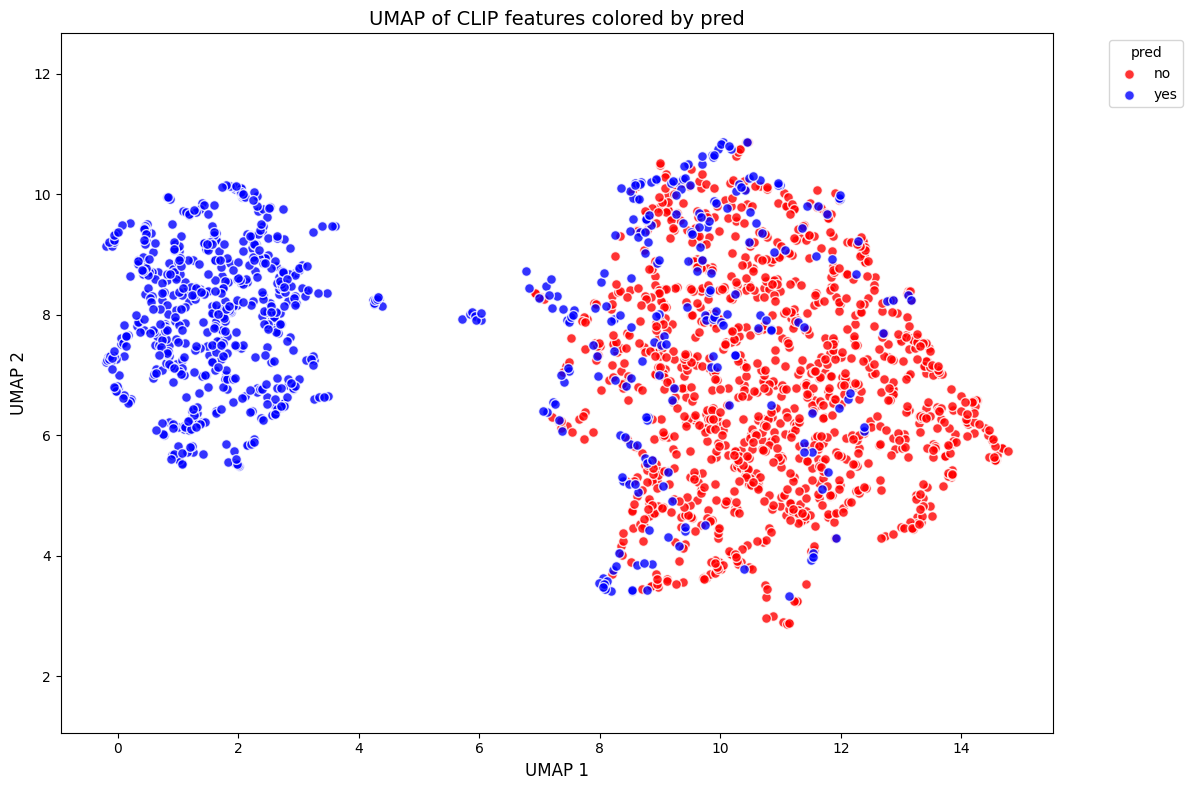

In [ ]:
clip_runner_fair_coef2_01.plot_latent_space("pred")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


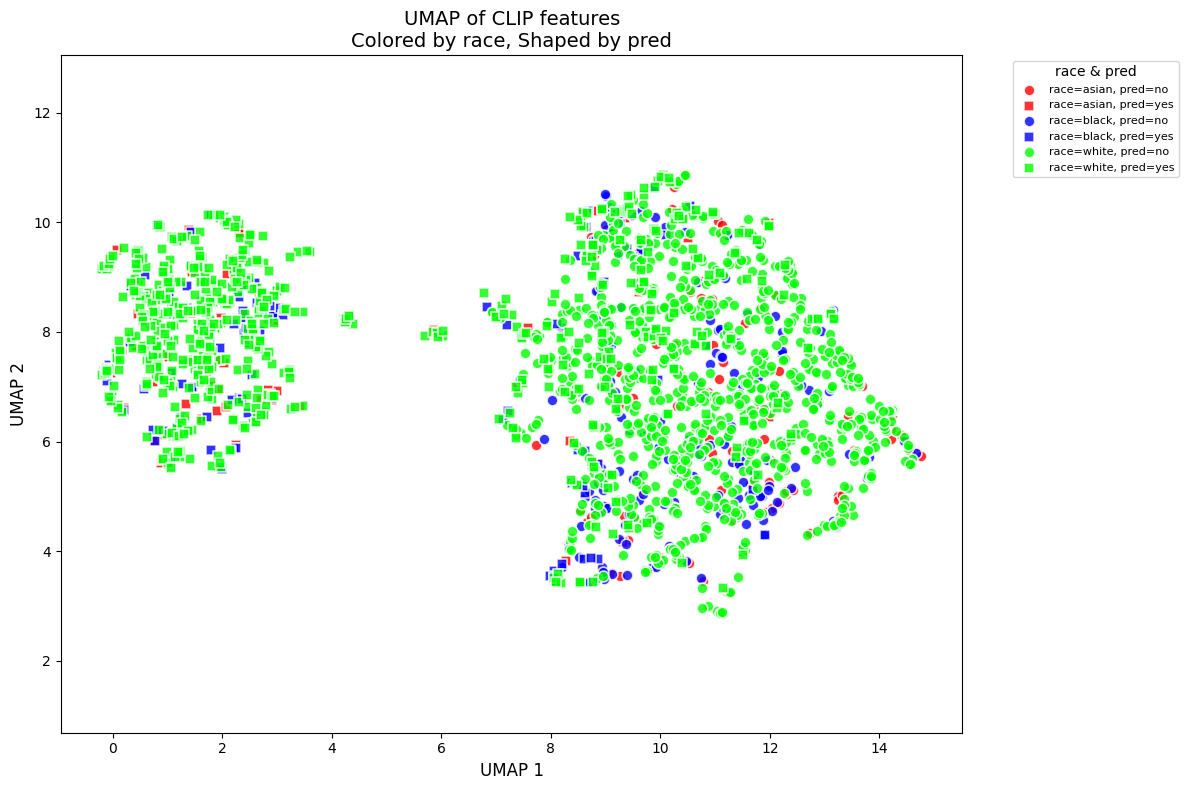

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


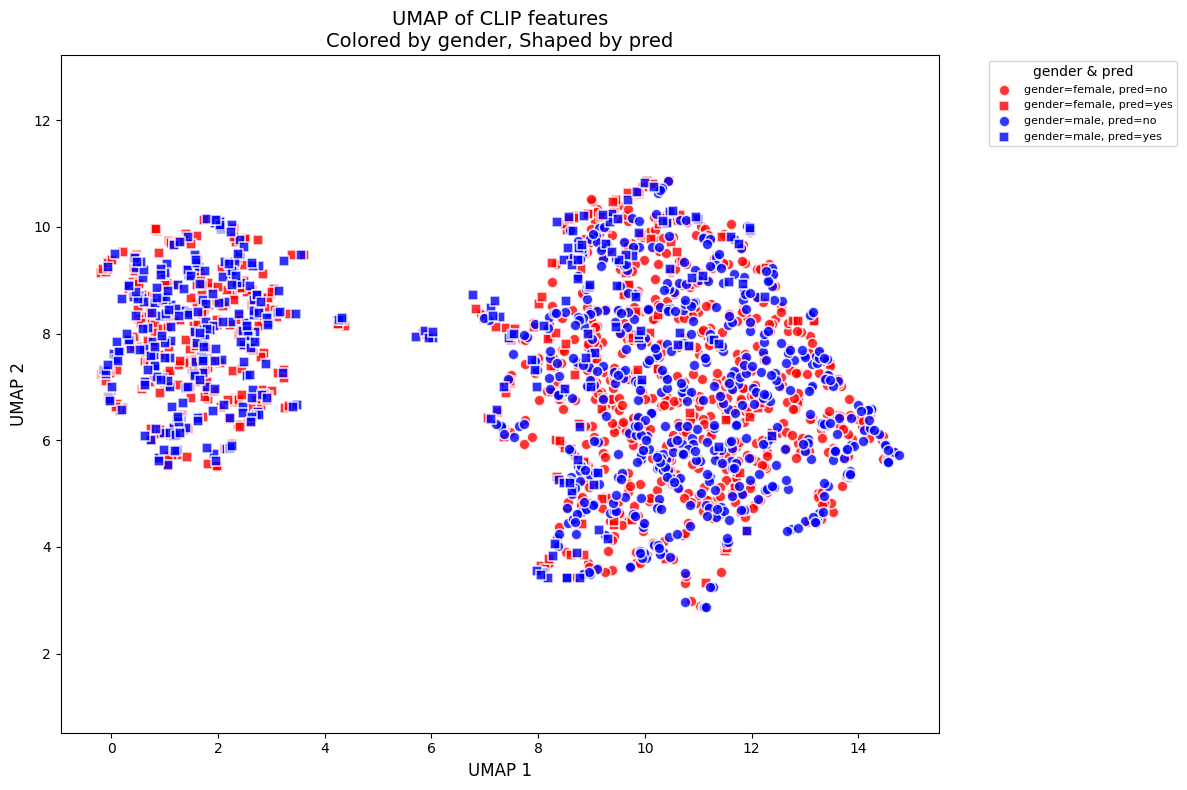

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


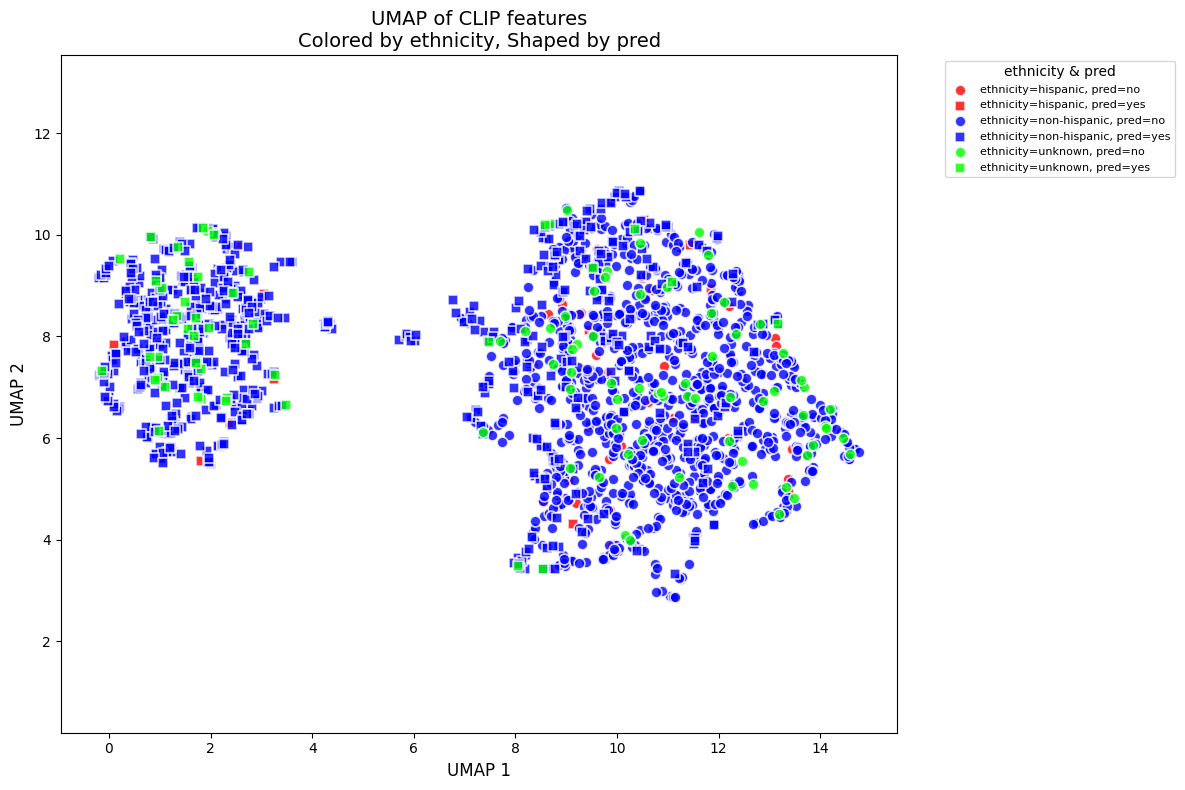

In [ ]:
clip_runner_fair_coef2_01.plot_latent_space(protected_attr="race", label_col="pred")
clip_runner_fair_coef2_01.plot_latent_space(protected_attr="gender", label_col="pred")
clip_runner_fair_coef2_01.plot_latent_space(protected_attr="ethnicity", label_col="pred")

test avec d'autres coefs

restucture the code : /!\

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) # Must set jit=False for training

if device == "cpu":
    model.float()
else:
    clip.model.convert_weights(model)

# Loss functions
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

trainable_keywords = [
    'transformer.resblocks.10',
    'transformer.resblocks.11',
    'visual.transformer.resblocks.10',
    'visual.transformer.resblocks.11',
    #'ln_final',
    'text_projection',
    'visual.proj',
]


num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = 0

for name, param in model.named_parameters():
    if any(k in name for k in trainable_keywords):
        param.requires_grad = True
        num_trainable_params += param.numel()
    else:
        param.requires_grad = False

print(f"Trainable params: {num_trainable_params} out of {num_params} ({100*num_trainable_params/num_params:.2f}%)")

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5
)

protected_attribute = 'race'

nb_epochs = 30

batch_size = 32

contrastive_coef = 1.0
fairness_coef = 3.0 ################

for epoch in range(nb_epochs):
    model.train()
    total_epoch_loss = 0
    num_batches = 0

    batches = custom_batches(df_train, protected_attribute, batch_size=batch_size)

    for batch_idx, batch_df in enumerate(batches):
        optimizer.zero_grad()

        loss = compute_loss(model, preprocess, batch_df, protected_attribute, coef1=contrastive_coef, coef2=fairness_coef)
        loss.backward()
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        total_epoch_loss += loss.item()
        num_batches += 1


    avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0
    print(f"EPOCH {epoch + 1} - Average Loss: {avg_epoch_loss:.4f}")


clip_runner_fair_coef2_3 = RunCLIP(list(df["slo_fundus"]), metadata = df.drop("slo_fundus", axis=1))
clip_runner_fair_coef2_3.setModel(model)
clip_runner_fair_coef2_3.setClasses({
   "pred": [("a medical picture of a person with glaucoma", "yes") , ("a medical picture of a person without glaucoma", "no")]
})

clip_runner_fair_coef2_3.runPreds(plot_preview=False)



merge_fair_coef2_3 = df.copy().drop(columns = [c for c in df.columns if c != "glaucoma"])
merge_fair_coef2_3["pred"] = clip_runner_fair_coef2_3.run_result["pred"]

print(f"Fine-tuned Fair Model Test Set Accuracy: { (merge_fair_coef2_3['glaucoma'] == merge_fair_coef2_3['pred']).sum() / len(merge_fair_coef2_3)*100 : .2f}%")
print("Fine-tuned Fair Model Number of yes predictions :" ,(clip_runner_fair_coef2_3.run_result["pred"]=="yes").sum())


resultat_fair_coef2_3 = clip_runner_fair_coef2_3.run_result.copy()
resultat_fair_coef2_3["label"] = df["glaucoma"]
resultat_fair_coef2_3["race"] = df["race"]


print("\nAUC by Race (Fine-tuned Fair Model):")
for race, group_df in resultat_fair_coef2_3.groupby("race"):
    if len(group_df["label"].unique()) > 1:
      true_labels_binary = group_df["label"].apply(lambda x: 1 if x == "yes" else 0)
      auc = roc_auc_score(true_labels_binary, group_df["similarity_score"])
      print(f"[{race}] AUC: {auc:.3f}")
    else:
      print(f"[{race}] AUC: Cannot compute (only one class present)")


from google.colab import files

df_fair_preds_coef2_3 = df.copy()
df_fair_preds_coef2_3["pred"] = clip_runner_fair_coef2_3.run_result["pred"]
csv_filename = "df_fair_preds_coef2_3.csv"
df_fair_preds_coef2_3.to_csv(csv_filename, index=False)
files.download(csv_filename)

print(f"Predictions exported to {csv_filename} and ready for download.")

Trainable params: 21135872 out of 151277313 (13.97%)
EPOCH 1 - Average Loss: 3.4305
EPOCH 2 - Average Loss: 3.3746
EPOCH 3 - Average Loss: 3.3366
EPOCH 4 - Average Loss: 3.2950
EPOCH 5 - Average Loss: 3.2302
EPOCH 6 - Average Loss: 3.1550
EPOCH 7 - Average Loss: 3.1049
EPOCH 8 - Average Loss: 3.0713
EPOCH 9 - Average Loss: 3.0290
EPOCH 10 - Average Loss: 2.9896
EPOCH 11 - Average Loss: 2.9136
EPOCH 12 - Average Loss: 2.9081
EPOCH 13 - Average Loss: 2.9021
EPOCH 14 - Average Loss: 2.8815
EPOCH 15 - Average Loss: 2.8886
EPOCH 16 - Average Loss: 2.8720
EPOCH 17 - Average Loss: 2.8527
EPOCH 18 - Average Loss: 2.8504
EPOCH 19 - Average Loss: 2.8665
EPOCH 20 - Average Loss: 2.8476
EPOCH 21 - Average Loss: 2.8438
EPOCH 22 - Average Loss: 2.8439
EPOCH 23 - Average Loss: 2.8577
EPOCH 24 - Average Loss: 2.8300
EPOCH 25 - Average Loss: 2.8325
EPOCH 26 - Average Loss: 2.8266
EPOCH 27 - Average Loss: 2.8187
EPOCH 28 - Average Loss: 2.8277
EPOCH 29 - Average Loss: 2.8211
EPOCH 30 - Average Loss: 2.8

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions exported to df_fair_preds_coef2_3.csv and ready for download.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


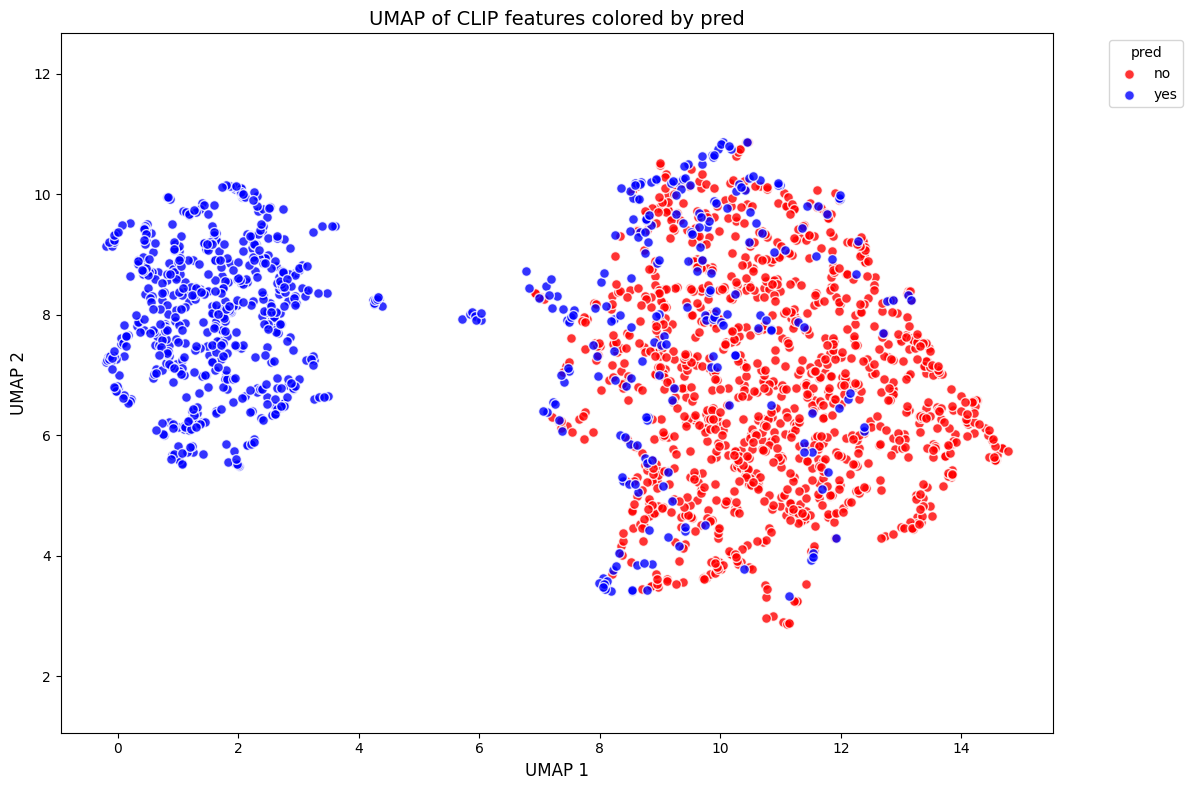

In [ ]:
clip_runner_fair_coef2_3.plot_latent_space("pred")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


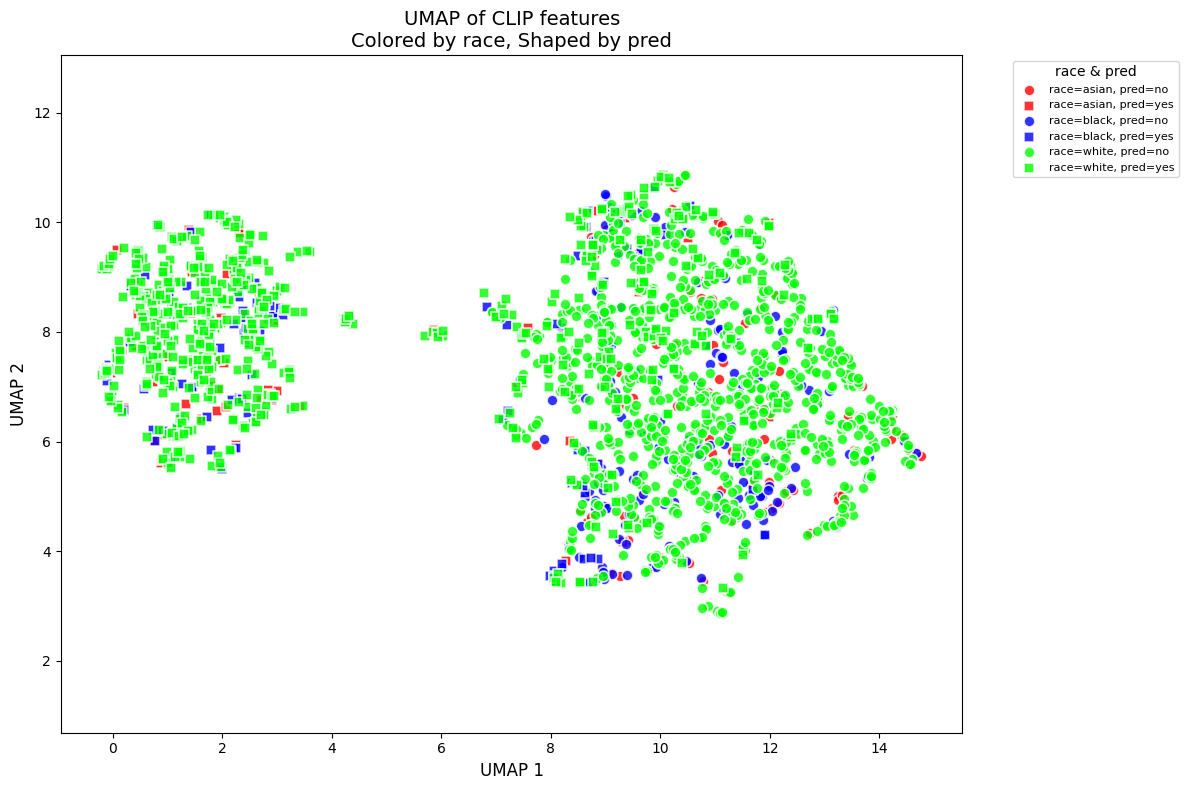

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


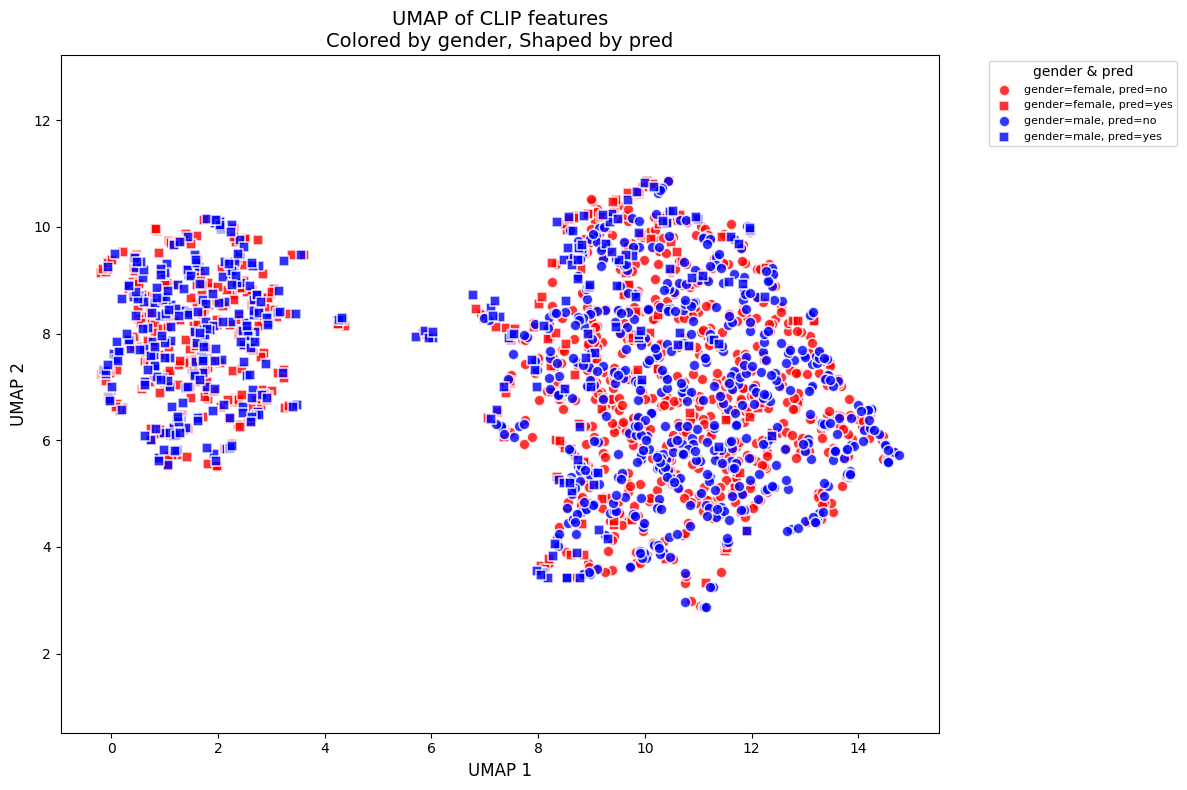

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


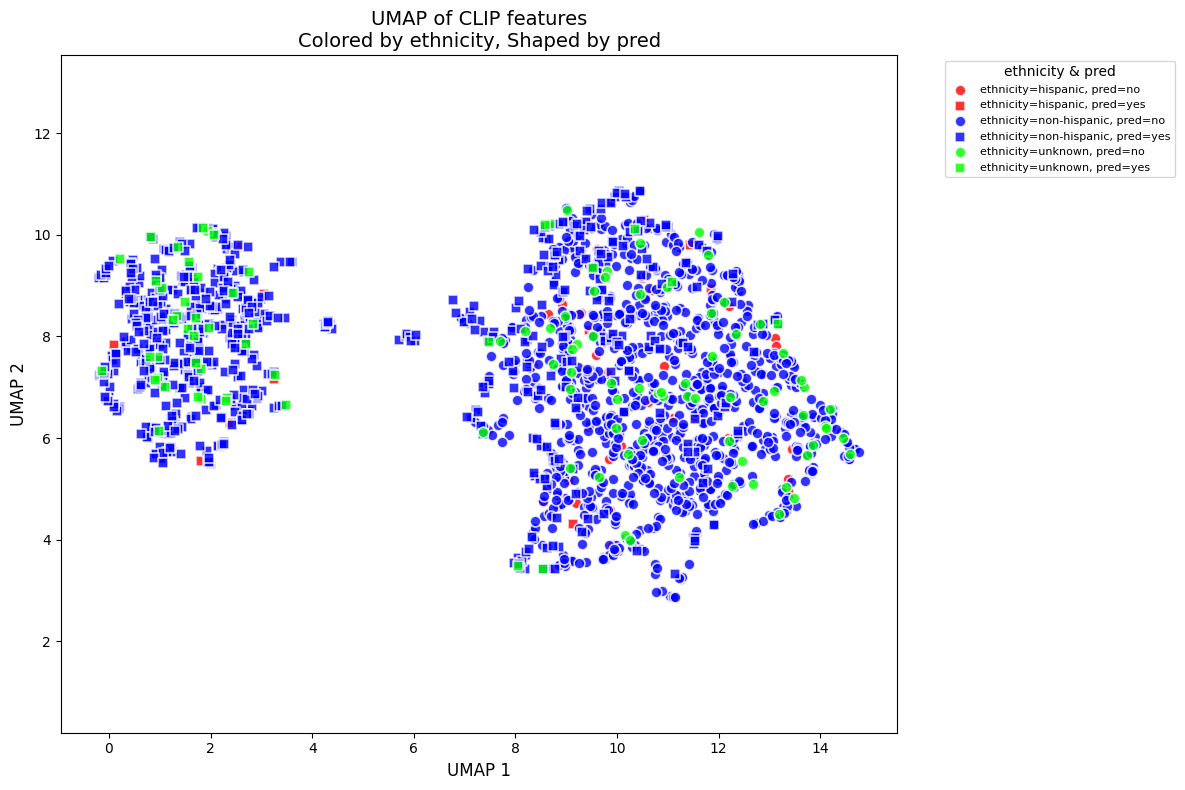

In [ ]:
clip_runner_fair_coef2_3.plot_latent_space(protected_attr="race", label_col="pred")
clip_runner_fair_coef2_3.plot_latent_space(protected_attr="gender", label_col="pred")
clip_runner_fair_coef2_3.plot_latent_space(protected_attr="ethnicity", label_col="pred")

# FairClip Using Linear Probe

In [ ]:
#NOTE: UTILE de le monter plus haut
from google.colab import files

def save_model_parameters(model, path):
  """Saves the state dictionary of a PyTorch model."""
  torch.save(model.state_dict(), path)
  print(f"Model parameters saved to {path}")

def load_model_parameters(model, path, device):
  """Loads the state dictionary into a PyTorch model."""
  model.load_state_dict(torch.load(path, map_location=device))
  model.to(device)
  print(f"Model parameters loaded from {path}")


# --- Saving the parameters of the trained clip_runner_fair model ---
# Make sure you have run the fair fine-tuning section first so 'model' is the trained model
model_save_path = "/content/clip_runner_fair_model_params.pth"
#save_model_parameters(model, model_save_path)


In [ ]:
# Download the model

#files.download(model_save_path)

In [ ]:
file_id = "11GoW1CBVt8pym9p0sFXqo2b_cKffsFhE"
output = "fair_clip.pth"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
load_model_parameters(model, output, device)

Downloading...
From (original): https://drive.google.com/uc?id=11GoW1CBVt8pym9p0sFXqo2b_cKffsFhE
From (redirected): https://drive.google.com/uc?id=11GoW1CBVt8pym9p0sFXqo2b_cKffsFhE&confirm=t&uuid=f6252f13-56de-438c-9f19-98bd2c3d91c7
To: /content/fair_clip.pth
100%|██████████| 354M/354M [00:09<00:00, 36.4MB/s]


Model parameters loaded from fair_clip.pth


In [ ]:

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Linear(512, 2).float().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)


In [ ]:
def compute_accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).sum().item(), labels.size(0)

In [ ]:
nb_epochs = 8

In [ ]:

for epoch in range(nb_epochs):
    # Training loop
    classifier.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = torch.tensor([1 if label == 'image of an eye with glaucoma' else 0 for label in labels]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
        image_features = image_features.float()

        logits = classifier(image_features)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct, total = compute_accuracy(logits, labels)
        train_correct += correct
        train_total += total

    train_acc = train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    classifier.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = torch.tensor([1 if label == 'image of an eye with glaucoma' else 0 for label in labels]).to(device)

            image_features = model.encode_image(images).float()
            logits = classifier(image_features)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            correct, total = compute_accuracy(logits, labels)
            val_correct += correct
            val_total += total

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.2814, Train Acc: 0.9444 | Val Loss: 0.6833, Val Acc: 0.6820
Epoch 2 | Train Loss: 0.1014, Train Acc: 0.9796 | Val Loss: 0.8161, Val Acc: 0.6790
Epoch 3 | Train Loss: 0.0723, Train Acc: 0.9807 | Val Loss: 0.9106, Val Acc: 0.6770
Epoch 4 | Train Loss: 0.0619, Train Acc: 0.9806 | Val Loss: 0.9832, Val Acc: 0.6720
Epoch 5 | Train Loss: 0.0570, Train Acc: 0.9813 | Val Loss: 1.0441, Val Acc: 0.6720
Epoch 6 | Train Loss: 0.0542, Train Acc: 0.9811 | Val Loss: 1.0892, Val Acc: 0.6700
Epoch 7 | Train Loss: 0.0525, Train Acc: 0.9819 | Val Loss: 1.1311, Val Acc: 0.6710
Epoch 8 | Train Loss: 0.0512, Train Acc: 0.9813 | Val Loss: 1.1601, Val Acc: 0.6710


In [ ]:

def compute_metrics(logits, labels):
    """Computes accuracy, predictions, and probabilities."""
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    # Get probabilities for the positive class (assuming index 1 is positive)
    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
    return correct, total, preds.cpu().numpy(), probs

def evaluate_model(model, classifier, dataloader, criterion, device):
    """Evaluate model on given dataloader and compute accuracy and AUC."""
    model.eval()
    classifier.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Convert string labels to binary integer labels
            labels_binary = torch.tensor([1 if label == 'image of an eye with glaucoma' else 0 for label in labels]).to(device)

            # Extract CLIP features
            image_features = model.encode_image(images).float()

            # Classify using the linear probe
            logits = classifier(image_features)
            loss = criterion(logits, labels_binary)
            total_loss += loss.item()

            # Compute metrics using binary labels
            correct, total, preds, probs = compute_metrics(logits, labels_binary)
            all_preds.extend(preds)
            all_labels.extend(labels_binary.cpu().numpy())
            all_probs.extend(probs)

    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    # Compute AUC if there are at least two classes present in the labels
    auc = -1 # Default to -1 if AUC cannot be computed
    if len(np.unique(all_labels)) > 1:
      auc = roc_auc_score(all_labels, all_probs)
    else:
      print("Warning: Only one class present in evaluation labels. AUC cannot be computed.")


    return avg_loss, accuracy, auc, all_preds, all_labels, all_probs


## Evaluation after Linear Probe Training

In [ ]:

# Assuming 'model' is the frozen CLIP model and 'classifier' is the trained linear probe
# Assuming 'test_loader' is defined and contains the test dataset
test_loader = DataLoader(test_dataset, batch_size=16) # Define test_loader

test_loss, test_acc, test_auc, test_preds, test_labels, test_probs = evaluate_model(model, classifier, test_loader, criterion, device)

print(f"\n--- Evaluation of Linear Probe Classifier ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
if test_auc != -1:
    print(f"Test AUC: {test_auc:.4f}")
else:
    print(f"Test AUC: Cannot compute (only one class present)")

# Optionally, you can create a DataFrame with test results
df_linear_probe_preds = df.copy() # Assuming df is the original test dataframe
# Map binary predictions back to original string labels if needed
df_linear_probe_preds["pred"] = ["yes" if p == 1 else "no" for p in test_preds]
df_linear_probe_preds["probability_glaucoma"] = test_probs # Probability of the positive class

csv_filename_linear_probe = "df_linear_probe_preds.csv"
df_linear_probe_preds.to_csv(csv_filename_linear_probe, index=False)
print(f"Linear probe predictions exported to {csv_filename_linear_probe}")

# To download the CSV file (if running in Colab)
# files.download(csv_filename_linear_probe)



--- Evaluation of Linear Probe Classifier ---
Test Loss: 1.1577
Test Accuracy: 0.6810
Test AUC: 0.7413
Linear probe predictions exported to df_linear_probe_preds.csv
